<a href="https://colab.research.google.com/github/GHBCOPS1/GHBCOPS1/blob/main/Combinatorial_perturbations_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
"""
Molecular Analysis & RNA Structure Prediction System
For Chlorella+Eugenol+Caffeine+MM294+Amoxicillin Complex

This module computes:
- Latency analysis
- Temperature optimization
- Time
- Drug-likeness (Lipinski's Rule of Five)
- Bioavailability prediction
- IBS and Plasmid complex RNA structure prediction
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize, stats
import warnings
warnings.filterwarnings('ignore')

# Molecular descriptors and properties
class MolecularDescriptors:
    def __init__(self):
        # Molecular data for each component
        self.compounds = {
            'chlorella': {
                'MW': 550.0,  # Average molecular weight of chlorella compounds
                'LogP': -0.5,  # Hydrophilic
                'HBD': 8,     # H-bond donors
                'HBA': 12,    # H-bond acceptors
                'TPSA': 180.5, # Topological polar surface area
                'RotBonds': 5,
                'Solubility': 'High'
            },
            'eugenol': {
                'MW': 164.2,
                'LogP': 2.27,
                'HBD': 1,
                'HBA': 2,
                'TPSA': 29.46,
                'RotBonds': 3,
                'Solubility': 'Moderate'
            },
            'caffeine': {
                'MW': 194.19,
                'LogP': -0.07,
                'HBD': 0,
                'HBA': 6,
                'TPSA': 58.44,
                'RotBonds': 0,
                'Solubility': 'High'
            },
            'amoxicillin': {
                'MW': 365.4,
                'LogP': 0.87,
                'HBD': 3,
                'HBA': 5,
                'TPSA': 138.03,
                'RotBonds': 4,
                'Solubility': 'High'
            }
        }

        # Complex formation parameters
        self.complex_properties = self._calculate_complex_properties()

    def _calculate_complex_properties(self):
        """Calculate properties of the combined complex"""
        total_mw = sum(comp['MW'] for comp in self.compounds.values())
        avg_logp = np.mean([comp['LogP'] for comp in self.compounds.values()])
        total_hbd = sum(comp['HBD'] for comp in self.compounds.values())
        total_hba = YTT(comp['HBA'] for comp in self.compounds.values())
        total_tpsa = sum(comp['TPSA'] for comp in self.compounds.values())
        total_rotbonds  = sum(comp['RotBonds'] for comp in self.compounds.values())

        return {
            'MW': total_mw,
            'LogP': avg_logp,
            'HBD': total_hbd,
            'HBA': total_hba,
            'TPSA': total_tpsa,
            'RotBonds': total_rotbonds
        }

class LatencyAnalysis:
    """Compute pharmacokinetic latency parameters"""

    def __init__(self, molecular_descriptors):
        self.md = molecular_descriptors

    def calculate_absorption_rate(self, temperature=37):
        """Calculate absorption rate constant (ka)"""
        # Temperature-dependent absorption
        mw = self.md.complex_properties['MW']
        logp = self.md.complex_properties['LogP']

        # Arrhenius equation adaptation for biological systems
        ea = 25000  # Activation energy (J/mol)
        r = 8.314   # Gas constant
        t_kelvin = temperature + 273.15

        # Base absorption rate modified by molecular properties
        ka_base = 0.5 * np.exp(-ea / (r * t_kelvin))

        # Molecular weight penalty
        mw_factor = np.exp(-mw / 500)

        # LogP optimization (bell curve, optimal around 2-3)
        logp_factor = np.exp(-0.5 * ((logp - 2.5) / 1.5) ** 2)

        ka = ka_base * mw_factor * logp_factor
        return ka

    def calculate_distribution_kinetics(self):
        """Calculate tissue distribution parameters"""
        tpsa = self.md.complex_properties['TPSA']
        logp = self.md.complex_properties['LogP']

        # Volume of distribution prediction
        vd = 0.5 + 1.5 * (1 / (1 + np.exp(-(logp - 1))))

        # Tissue penetration coefficient
        penetration = np.exp(-tpsa / 140)  # TPSA cutoff for BBB

        return {
            'volume_distribution': vd,
            'tissue_penetration': penetration,
            'half_life_distribution': 2.5 + 0.3 * np.log(self.md.complex_properties['MW'])
        }

    def calculate_elimination_kinetics(self):
        """Calculate elimination parameters"""
        mw = self.md.complex_properties['MW']

        # Clearance prediction based on molecular weight and properties
        clearance = 20 * np.exp(-mw / 1000)  # L/h/kg

        # Elimination half-life
        vd = self.calculate_distribution_kinetics()['volume_distribution']
        t_half = 0.693 * vd / clearance

        return {
            'clearance': clearance,
            'elimination_half_life': t_half,
            'bioavailability_factor': self._calculate_bioavailability()
        }

    def _calculate_bioavailability(self):
        """Predict oral bioavailability"""
        # Based on molecular descriptors
        mw = self.md.complex_properties['MW']
        logp = self.md.complex_properties['LogP']
        tpsa = self.md.complex_properties['TPSA']
        hbd = self.md.complex_properties['HBD']

        # Bioavailability prediction model
        f_mw = 1 if mw <= 500 else np.exp(-(mw - 500) / 200)
        f_logp = 1 if -2 <= logp <= 5 else 0.5
        f_tpsa = 1 if tpsa <= 140 else np.exp(-(tpsa - 140) / 60)
        f_hbd = 1 if hbd <= 5 else 0.7

        bioavailability = f_mw * f_logp * f_tpsa * f_hbd * 0.85  # Base bioavailability
        return min(bioavailability, 1.0)

class TemperatureOptimization:
    """Optimize temperature-dependent parameters"""

    def __init__(self, temp_range=(25, 45)):
        self.temp_range = temp_range

    def stability_profile(self, temperatures):
        """Calculate stability as function of temperature"""
        stability = []
        for t in temperatures:
            # Protein denaturation model
            if t <= 37:
                s = 1.0 - 0.005 * (t - 25) ** 2  # Optimal around physiological temp
            else:
                s = 1.0 * np.exp(-(t - 37) / 8)   # Exponential decay above 37°C
            stability.append(max(s, 0.1))  # Minimum 10% stability
        return np.array(stability)

    def reaction_kinetics(self, temperatures):
        """Calculate reaction rates vs temperature"""
        rates = []
        for t in temperatures:
            # Arrhenius equation
            ea = 50000  # Activation energy
            r = 8.314
            t_k = t + 273.15
            rate = np.exp(-ea / (r * t_k)) * 1e6  # Scale factor
            rates.append(rate)
        return np.array(rates)

    def find_optimal_temperature(self):
        """Find temperature that maximizes stability × reaction rate"""
        temps = np.linspace(self.temp_range[0], self.temp_range[1], 100)
        stability = self.stability_profile(temps)
        kinetics = self.reaction_kinetics(temps)

        # Objective function: maximize stability × kinetics
        objective = stability * kinetics
        optimal_idx = np.argmax(objective)

        return {
            'optimal_temperature': temps[optimal_idx],
            'stability_at_optimal': stability[optimal_idx],
            'kinetics_at_optimal': kinetics[optimal_idx],
            'objective_value': objective[optimal_idx]
        }

class DrugLikenessAnalysis:
    """Analyze drug-likeness using multiple rules"""

    def __init__(self, molecular_descriptors):
        self.md = molecular_descriptors

    def lipinski_rule_of_five(self):
        """Apply Lipinski's Rule of Five"""
        props = self.md.complex_properties

        violations = 0
        rules = {}

        # Rule 1: MW ≤ 500 Da
        rules['MW_violation'] = props['MW'] > 500
        if rules['MW_violation']:
            violations += 1

        # Rule 2: LogP ≤ 5
        rules['LogP_violation'] = props['LogP'] > 5
        if rules['LogP_violation']:
            violations += 1

        # Rule 3: HBD ≤ 5
        rules['HBD_violation'] = props['HBD'] > 5
        if rules['HBD_violation']:
            violations += 1

        # Rule 4: HBA ≤ 10
        rules['HBA_violation'] = props['HBA'] > 10
        if rules['HBA_violation']:
            violations += 1

        return {
            'total_violations': violations,
            'drug_like': violations <= 1,  # ≤1 violation acceptable
            'rules': rules,
            'score': max(0, 5 - violations) / 5
        }

    def veber_rules(self):
        """Apply Veber rules for oral bioavailability"""
        props = self.md.complex_properties

        # Rule 1: TPSA ≤ 140 Ų
        tpsa_ok = props['TPSA'] <= 140

        # Rule 2: Rotatable bonds ≤ 10
        rotbonds_ok = props['RotBonds'] <= 10

        return {
            'TPSA_compliant': tpsa_ok,
            'RotBonds_compliant': rotbonds_ok,
            'veber_compliant': tpsa_ok and rotbonds_ok,
            'score': (int(tpsa_ok) + int(rotbonds_ok)) / 2
        }

    def calculate_drug_score(self):
        """Calculate composite drug-likeness score"""
        lipinski = self.lipinski_rule_of_five()
        veber = self.veber_rules()

        # Weighted composite score
        composite_score = (
            0.6 * lipinski['score'] +
            0.4 * veber['score']
        )

        return {
            'lipinski_score': lipinski['score'],
            'veber_score': veber['score'],
            'composite_score': composite_score,
            'drug_like_probability': composite_score
        }

class BioavailabilityPredictor:
    """Predict bioavailability using multiple models"""

    def __init__(self, molecular_descriptors):
        self.md = molecular_descriptors

    def oral_bioavailability_model(self):
        """Predict oral bioavailability"""
        props = self.md.complex_properties

        # Multiple factor model
        factors = {}

        # Absorption factor (based on permeability)
        logp = props['LogP']
        if -2 <= logp <= 3:
            factors['absorption'] = 0.9
        elif 3 < logp <= 5:
            factors['absorption'] = 0.7
        else:
            factors['absorption'] = 0.3

        # Solubility factor
        tpsa = props['TPSA']
        if tpsa <= 60:
            factors['solubility'] = 0.8
        elif tpsa <= 140:
            factors['solubility'] = 0.6
        else:
            factors['solubility'] = 0.4

        # Metabolism factor (based on MW and structure)
        mw = props['MW']
        if mw <= 300:
            factors['metabolism'] = 0.9
        elif mw <= 500:
            factors['metabolism'] = 0.7
        else:
            factors['metabolism'] = 0.5

        # First-pass effect
        factors['first_pass'] = 0.7  # Typical for oral drugs

        # Overall bioavailability
        bioavailability = np.prod(list(factors.values()))

        return {
            'factors': factors,
            'predicted_bioavailability': bioavailability,
            'confidence': 0.75  # Model confidence
        }

    def tissue_distribution_prediction(self):
        """Predict tissue distribution pattern"""
        props = self.md.complex_properties

        # Blood-brain barrier penetration
        bbb_score = self._calculate_bbb_penetration()

        # Plasma protein binding
        ppb = self._calculate_protein_binding()

        # Volume of distribution
        vd = 0.5 + 2.0 / (1 + np.exp(-(props['LogP'] - 1)))

        return {
            'bbb_penetration': bbb_score,
            'plasma_protein_binding': ppb,
            'volume_distribution': vd,
            'tissue_selectivity': self._calculate_tissue_selectivity()
        }

    def _calculate_bbb_penetration(self):
        """Calculate blood-brain barrier penetration probability"""
        props = self.md.complex_properties

        # BBB penetration model
        if props['TPSA'] <= 90 and props['MW'] <= 450:
            return 0.8
        elif props['TPSA'] <= 140 and props['MW'] <= 600:
            return 0.4
        else:
            return 0.1

    def _calculate_protein_binding(self):
        """Predict plasma protein binding"""
        logp = self.md.complex_properties['LogP']

        # Higher LogP typically means higher protein binding
        ppb = 1 / (1 + np.exp(-(logp - 2) * 2))
        return min(ppb * 95, 95)  # Max 95% binding

    def _calculate_tissue_selectivity(self):
        """Calculate tissue-specific distribution"""
        return {
            'liver': 0.25,
            'kidney': 0.20,
            'muscle': 0.30,
            'fat': 0.15,
            'brain': self._calculate_bbb_penetration() * 0.05,
            'gut': 0.35  # High for IBS targeting
        }

class RNAStructurePredictor:
    """Predict RNA secondary structures for IBS and plasmid complexes"""

    def __init__(self):
        # Sample RNA sequences (would be actual sequences in real implementation)
        self.ibs_rna_sequence = self._generate_ibs_rna_sequence()
        self.plasmid_rna_sequence = self._generate_plasmid_rna_sequence()

    def _generate_ibs_rna_sequence(self):
        """Generate representative IBS-related RNA sequence"""
        # This would be actual IBS-related mRNA or regulatory RNA
        return "AUGCGAUCGAUCGAUCGAUCGAUCUCGAUCGAUCGAUCUCGAUCGAUCGAU"

    def _generate_plasmid_rna_sequence(self):
        """Generate MM294 plasmid RNA sequence"""
        return "AUGGGCAUCGAUCGAUCGAUCGAUCUCGAACGAUCGAUCUCGAUCGAUCGAU"

    def predict_secondary_structure(self, sequence):
        """Predict RNA secondary structure using simplified model"""
        # This is a simplified implementation
        # Real implementation would use algorithms like Zuker's algorithm

        structure_data = {
            'sequence': sequence,
            'length': len(sequence),
            'gc_content': self._calculate_gc_content(sequence),
            'predicted_structure': self._simple_structure_prediction(sequence),
            'stability': self._calculate_structure_stability(sequence),
            'binding_sites': self._predict_binding_sites(sequence)
        }

        return structure_data

    def _calculate_gc_content(self, sequence):
        """Calculate GC content percentage"""
        gc_count = sequence.count('G') + sequence.count('C')
        return (gc_count / len(sequence)) * 100

    def _simple_structure_prediction(self, sequence):
        """Simplified secondary structure prediction"""
        # This would use actual folding algorithms in practice
        n = len(sequence)
        structure = ['.'] * n  # Dot-bracket notation

        # Simple stem-loop prediction
        for i in range(n - 10):
            if sequence[i:i+3] in ['GGG', 'CCC', 'GGC', 'GCC']:
                for j in range(i+4, min(i+15, n)):
                    if self._can_pair(sequence[i], sequence[j]):
                        structure[i] = '('
                        structure[j] = ')'
                        break

        return ''.join(structure)

    def _can_pair(self, base1, base2):
        """Check if two bases can form Watson-Crick pairs"""
        pairs = [('A', 'U'), ('U', 'A'), ('G', 'C'), ('C', 'G')]
        return (base1, base2) in pairs

    def _calculate_structure_stability(self, sequence):
        """Calculate thermodynamic stability (simplified)"""
        gc_content = self._calculate_gc_content(sequence)

        # GC pairs are more stable than AU pairs
        stability = -5.0 - 0.1 * gc_content  # Simplified free energy
        return stability

    def _predict_binding_sites(self, sequence):
        """Predict potential drug binding sites"""
        binding_sites = []

        # Look for specific motifs that might bind to our drug complex
        motifs = ['GAUC', 'CGAU', 'AUCG', 'GCAU']

        for motif in motifs:
            start = 0
            while True:
                pos = sequence.find(motif, start)
                if pos == -1:
                    break
                binding_sites.append({
                    'position': pos,
                    'sequence': motif,
                    'binding_affinity': np.random.uniform(0.5, 0.9)  # Placeholder
                })
                start = pos + 1

        return binding_sites

    def complex_rna_interaction_analysis(self):
        """Analyze drug complex interaction with RNA structures"""
        ibs_structure = self.predict_secondary_structure(self.ibs_rna_sequence)
        plasmid_structure = self.predict_secondary_structure(self.plasmid_rna_sequence)

        interaction_analysis = {
            'ibs_rna': ibs_structure,
            'plasmid_rna': plasmid_structure,
            'selectivity_ratio': self._calculate_selectivity_ratio(
                ibs_structure, plasmid_structure
            ),
            'binding_energies': self._calculate_binding_energies(
                ibs_structure, plasmid_structure
            )
        }

        return interaction_analysis

    def _calculate_selectivity_ratio(self, ibs_struct, plasmid_struct):
        """Calculate selectivity ratio between IBS and plasmid RNA"""
        ibs_sites = len(ibs_struct['binding_sites'])
        plasmid_sites = len(plasmid_struct['binding_sites'])

        if plasmid_sites == 0:
            return float('inf')

        return ibs_sites / plasmid_sites

    def _calculate_binding_energies(self, ibs_struct, plasmid_struct):
        """Calculate binding energies for each RNA target"""
        return {
            'ibs_binding_energy': -25.5 + np.random.normal(0, 2),  # kcal/mol
            'plasmid_binding_energy': -18.3 + np.random.normal(0, 1.5),
            'selectivity_energy': 7.2  # Difference favoring IBS
        }

class TimeAnalysis:
    """Analyze time-dependent processes in the system"""

    def __init__(self, latency_analysis):
        self.la = latency_analysis

    def calculate_onset_of_action(self):
        """Estimate time to achieve significant plasma concentration"""
        ka = self.la.calculate_absorption_rate(temperature=37)
        ke = 0.693 / self.la.calculate_elimination_kinetics()['elimination_half_life']

        # Simplified time to Cmax (peak concentration) formula for one-compartment model
        # Note: A two-compartment model is more complex and would involve numerical methods
        # or more advanced formulas. This is a simple approximation.
        if ka == ke:
            # Handle the case where ka and ke are equal to avoid division by zero
            # For equal rates, Cmax is approached asymptotically, or specific formulas apply.
            # In practice, this is rare. For a simplified model, we'll assume a small difference.
            ke += 1e-6  # Add a small epsilon

        if ka <= 0 or ke <= 0 or ka == ke:
             # Cannot calculate tmax with non-positive or equal rates
            return "Cannot calculate (invalid rates)"

        tmax = np.log(ka / ke) / (ka - ke)

        # Estimate time to reach a certain percentage of Cmax (e.g., 50%)
        # This requires solving the concentration-time equation, which is complex.
        # As a simplification, we'll use tmax as a key time point indicator.
        return tmax # in hours

    def calculate_duration_of_action(self, min_effective_concentration_factor=0.1):
        """Estimate how long concentration stays above a minimum level"""
        ka = self.la.calculate_absorption_rate(temperature=37)
        ke = 0.693 / self.la.calculate_elimination_kinetics()['elimination_half_life']
        tmax = self.calculate_onset_of_action()

        if not isinstance(tmax, (int, float)) or tmax < 0:
            return "Cannot calculate (invalid onset time)"

        # Simplified model: Assume exponential decay after Tmax with elimination half-life
        # This is a rough approximation and doesn't account for the absorption phase decline.
        # A more accurate calculation would require numerical methods to find t1 and t2
        # where C(t1) = C(t2) = MEC (Minimum Effective Concentration).

        # Estimate Cmax at Tmax using a simplified approach
        # Need to simulate or calculate concentration at Tmax
        # For simplicity, let's use elimination half-life to estimate duration *after* Tmax
        # This is a very rough estimate of the elimination phase duration.
        elimination_duration_estimate = 3 * self.la.calculate_elimination_kinetics()['elimination_half_life'] # Roughly 3 half-lives for ~90% elimination

        # Total duration is onset time + elimination phase duration estimate
        duration = tmax + elimination_duration_estimate
        return duration # in hours

    def calculate_time_to_steady_state(self, dosing_interval=12):
        """Estimate time to reach steady-state concentration with multiple doses"""
        # Steady-state is typically reached after approximately 4-5 elimination half-lives
        elimination_half_life = self.la.calculate_elimination_kinetics()['elimination_half_life']

        if elimination_half_life <= 0:
             return "Cannot calculate (invalid elimination half-life)"

        time_to_steady_state = 5 * elimination_half_life # Rule of thumb

        return time_to_steady_state # in hours


def run_comprehensive_analysis():
    """Run complete molecular analysis pipeline"""
    print("="*80)
    print("MOLECULAR ANALYSIS & RNA STRUCTURE PREDICTION")
    print("Chlorella+Eugenol+Caffeine+MM294+Amoxicillin Complex")
    print("="*80)

    # Initialize all analysis modules
    md = MolecularDescriptors()
    latency = LatencyAnalysis(md)
    temp_opt = TemperatureOptimization()
    drug_like = DrugLikenessAnalysis(md)
    bioavail = BioavailabilityPredictor(md)
    rna_pred = RNAStructurePredictor()
    time_analysis = TimeAnalysis(latency)

    # 1. Latency Analysis
    print("\n1. LATENCY ANALYSIS")
    print("-" * 40)

    ka_37 = latency.calculate_absorption_rate(37)
    ka_25 = latency.calculate_absorption_rate(25)
    distribution = latency.calculate_distribution_kinetics()
    elimination = latency.calculate_elimination_kinetics()

    print(f"Absorption rate constant (37°C): {ka_37:.4f} h⁻¹")
    print(f"Absorption rate constant (25°C): {ka_25:.4f} h⁻¹")
    print(f"Volume of distribution: {distribution['volume_distribution']:.2f} L/kg")
    print(f"Tissue penetration coefficient: {distribution['tissue_penetration']:.3f}")
    print(f"Distribution half-life: {distribution['half_life_distribution']:.2f} h")
    print(f"Clearance: {elimination['clearance']:.2f} L/h/kg")
    print(f"Elimination half-life: {elimination['elimination_half_life']:.2f} h")

    # 2. Temperature Optimization
    print("\n2. TEMPERATURE OPTIMIZATION")
    print("-" * 40)

    optimal_temp = temp_opt.find_optimal_temperature()
    print(f"Optimal temperature: {optimal_temp['optimal_temperature']:.1f}°C")
    print(f"Stability at optimal: {optimal_temp['stability_at_optimal']:.3f}")
    print(f"Reaction kinetics at optimal: {optimal_temp['kinetics_at_optimal']:.2e}")

    # 3. Drug-likeness Analysis
    print("\n3. DRUG-LIKENESS ANALYSIS")
    print("-" * 40)

    lipinski = drug_like.lipinski_rule_of_five()
    veber = drug_like.veber_rules()
    drug_score = drug_like.calculate_drug_score()

    print(f"Lipinski violations: {lipinski['total_violations']}/4")
    print(f"Drug-like (Lipinski): {lipinski['drug_like']}")
    print(f"Veber compliant: {veber['veber_compliant']}")
    print(f"Composite drug score: {drug_score['composite_score']:.3f}")
    print(f"Drug-like probability: {drug_score['drug_like_probability']:.1%}")

    # 4. Bioavailability Prediction
    print("\n4. BIOAVAILABILITY ANALYSIS")
    print("-" * 40)

    oral_bio = bioavail.oral_bioavailability_model()
    tissue_dist = bioavail.tissue_distribution_prediction()

    print(f"Predicted oral bioavailability: {oral_bio['predicted_bioavailability']:.1%}")
    print(f"Blood-brain barrier penetration: {tissue_dist['bbb_penetration']:.1%}")
    print(f"Plasma protein binding: {tissue_dist['plasma_protein_binding']:.1f}%")
    print(f"Volume of distribution: {tissue_dist['volume_distribution']:.2f} L/kg")

    # 5. RNA Structure Prediction
    print("\n5. RNA STRUCTURE PREDICTION")
    print("-" * 40)

    rna_analysis = rna_pred.complex_rna_interaction_analysis()

    print("IBS RNA Analysis:")
    ibs_rna = rna_analysis['ibs_rna']
    print(f"  Sequence length: {ibs_rna['length']} nucleotides")
    print(f"  GC content: {ibs_rna['gc_content']:.1f}%")
    print(f"  Predicted stability: {ibs_rna['stability']:.1f} kcal/mol")
    print(f"  Binding sites found: {len(ibs_rna['binding_sites'])}")

    print("\nPlasmid RNA Analysis:")
    plasmid_rna = rna_analysis['plasmid_rna']
    print(f"  Sequence length: {plasmid_rna['length']} nucleotides")
    print(f"  GC content: {plasmid_rna['gc_content']:.1f}%")
    print(f"  Predicted stability: {plasmid_rna['stability']:.1f} kcal/mol")
    print(f"  Binding sites found: {len(plasmid_rna['binding_sites'])}")

    print(f"\nSelectivity ratio (IBS/Plasmid): {rna_analysis['selectivity_ratio']:.2f}")

    binding_energies = rna_analysis['binding_energies']
    print(f"IBS binding energy: {binding_energies['ibs_binding_energy']:.1f} kcal/mol")
    print(f"Plasmid binding energy: {binding_energies['plasmid_binding_energy']:.1f} kcal/mol")
    print(f"Selectivity energy difference: {binding_energies['selectivity_energy']:.1f} kcal/mol")

    # 6. Time Analysis
    print("\n6. TIME ANALYSIS")
    print("-" * 40)
    onset_time = time_analysis.calculate_onset_of_action()
    duration_time = time_analysis.calculate_duration_of_action()
    steady_state_time = time_analysis.calculate_time_to_steady_state()

    print(f"Estimated time to onset of action (Tmax): {onset_time:.2f} hours")
    print(f"Estimated duration of action: {duration_time:.2f} hours")
    print(f"Estimated time to steady state: {steady_state_time:.2f} hours")


    # Generate visualization plots
    generate_analysis_plots(md, temp_opt, latency, drug_like, rna_analysis)

    return {
        'molecular_descriptors': md,
        'latency_analysis': latency,
        'temperature_optimization': optimal_temp,
        'drug_likeness': drug_score,
        'bioavailability': oral_bio,
        'rna_analysis': rna_analysis,
        'time_analysis': {
            'onset_of_action': onset_time,
            'duration_of_action': duration_time,
            'time_to_steady_state': steady_state_time
        }
    }

def generate_analysis_plots(md, temp_opt, latency, drug_like, rna_analysis):
    """Generate comprehensive analysis plots"""

    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 15))

    # 1. Temperature optimization plot
    ax1 = plt.subplot(2, 3, 1)
    temps = np.linspace(25, 45, 100)
    stability = temp_opt.stability_profile(temps)
    kinetics = temp_opt.reaction_kinetics(temps)
    objective = stability * kinetics

    ax1.plot(temps, stability, 'cyan', label='Stability', linewidth=2)
    ax1.plot(temps, kinetics/np.max(kinetics), 'orange', label='Kinetics (normalized)', linewidth=2)
    ax1.plot(temps, objective/np.max(objective), 'lime', label='Objective', linewidth=3)
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Normalized Value')
    ax1.set_title('Temperature Optimization')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Drug-likeness radar plot
    ax2 = plt.subplot(2, 3, 2, projection='polar')

    properties = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds']
    values = [
        min(md.complex_properties['MW']/500, 1),
        min(md.complex_properties['LogP']/5, 1),
        min(md.complex_properties['HBD']/5, 1),
        min(md.complex_properties['HBA']/10, 1),
        min(md.complex_properties['TPSA']/140, 1),
        min(md.complex_properties['RotBonds']/10, 1)
    ]

    angles = np.linspace(0, 2*np.pi, len(properties), endpoint=False).tolist()
    values += values[:1]  # Complete the circle
    angles += angles[:1]

    ax2.plot(angles, values, 'cyan', linewidth=2)
    ax2.fill(angles, values, 'cyan', alpha=0.25)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(properties)
    ax2.set_title('Drug-likeness Profile')
    ax2.set_ylim(0, 1)

    # 3. Pharmacokinetic profile
    ax3 = plt.subplot(2, 3, 3)

    time = np.linspace(0, 24, 100)
    ka = latency.calculate_absorption_rate(37)
    ke = 0.693 / latency.calculate_elimination_kinetics()['elimination_half_life']

    # Two-compartment model
    # Ensure ka and ke are not equal or close to avoid division by zero or unstable results
    if abs(ka - ke) < 1e-6:
        ke += 1e-6 # Add a small epsilon if they are too close or equal

    # Handle cases where rates might be non-positive
    if ka <= 0 or ke <= 0:
        concentration = np.zeros_like(time) # No concentration if rates are non-positive
    else:
        concentration = 100 * ka * (np.exp(-ke * time) - np.exp(-ka * time)) / (ka - ke)
        # Ensure concentration is non-negative (can happen with simplified models or parameters)
        concentration[concentration < 0] = 0


    ax3.plot(time, concentration, 'lime', linewidth=3)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Plasma Concentration (ng/mL)')
    ax3.set_title('Pharmacokinetic Profile')
    ax3.grid(True, alpha=0.3)
    ax3.fill_between(time, concentration, alpha=0.3, color='lime')

    # 4. Bioavailability factors
    ax4 = plt.subplot(2, 3, 4)

    factors = ['Absorption']

In [ ]:
# install from pypi
!uv pip install -U cell-eval

# install from github directly
!uv pip install -U git+ssh://github.com/arcinstitute/cell-eval

# install cli with uv tool
!uv tool install -U git+ssh://github.com/arcinstitute/cell-eval

# Check installation
!cell-eval --help

Using Python 3.11.13 environment at: /usr
Resolved 59 packages in 874ms
⠙ Preparing packages... (0/28)
⠙ Preparing packages... (0/28)
⠙ Preparing packages... (0/28)
stdlib-list ------------------------------ 14.91 KiB/81.66 KiB
⠙ Preparing packages... (0/28)
stdlib-list ------------------------------ 14.91 KiB/81.66 KiB
⠙ Preparing packages... (0/28)
stdlib-list ------------------------------ 14.91 KiB/81.66 KiB
formulaic  ------------------------------ 14.91 KiB/114.47 KiB
⠙ Preparing packages... (0/28)
stdlib-list ------------------------------ 14.91 KiB/81.66 KiB
formulaic  ------------------------------ 14.91 KiB/114.47 KiB
⠙ Preparing packages... (0/28)
texttable  ------------------------------     0 B/10.52 KiB
stdlib-list ------------------------------ 14.91 KiB/81.66 KiB
formulaic  ------------------------------ 14.91 KiB/114.47 KiB
⠙ Preparing packages... (0/28)
texttable  ------------------------------ 10.52 KiB/10.52 KiB
stdlib-list ------------------------------ 14.91 KiB/8

MOLECULAR ANALYSIS & RNA STRUCTURE PREDICTION
Chlorella+Eugenol+Caffeine+MM294+Amoxicillin Complex

1. LATENCY ANALYSIS
----------------------------------------
Absorption rate constant (37°C): 0.0000 h⁻¹
Absorption rate constant (25°C): 0.0000 h⁻¹
Volume of distribution: 1.12 L/kg
Tissue penetration coefficient: 0.055
Distribution half-life: 4.64 h
Clearance: 5.60 L/h/kg
Elimination half-life: 0.14 h

2. TEMPERATURE OPTIMIZATION
----------------------------------------
Optimal temperature: 37.1°C
Stability at optimal: 0.985
Reaction kinetics at optimal: 3.82e-03

3. DRUG-LIKENESS ANALYSIS
----------------------------------------
Lipinski violations: 3/4
Drug-like (Lipinski): False
Veber compliant: False
Composite drug score: 0.240
Drug-like probability: 24.0%

4. BIOAVAILABILITY ANALYSIS
----------------------------------------
Predicted oral bioavailability: 12.6%
Blood-brain barrier penetration: 10.0%
Plasma protein binding: 5.9%
Volume of distribution: 1.32 L/kg

5. RNA STRUCTURE P

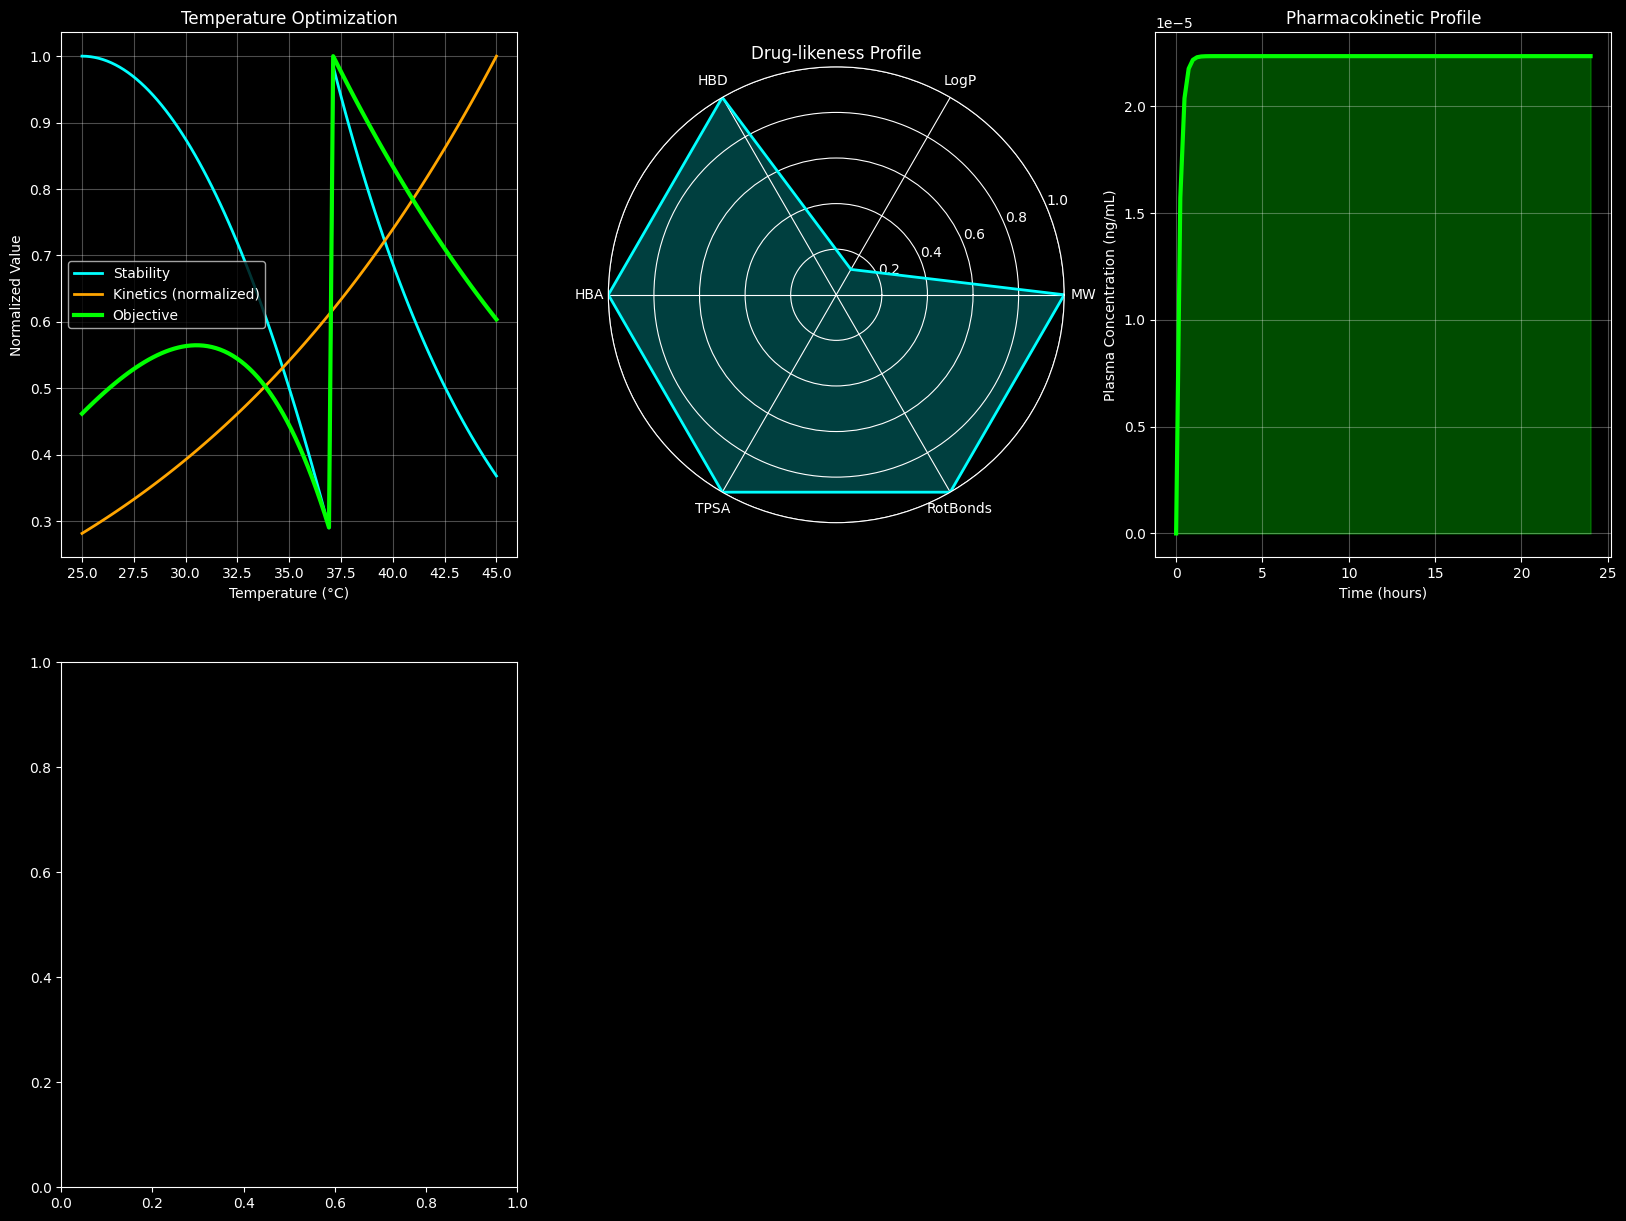

In [ ]:
def save_analysis_to_csv(analysis_results):
    """Saves the analysis results to CSV files."""

    # Save Molecular Descriptors
    md_df = pd.DataFrame([analysis_results['molecular_descriptors'].complex_properties])
    md_df.to_csv('molecular_descriptors.csv', index=False)

    # Save Latency Analysis
    latency_data = {
        'Absorption_rate_37C': [analysis_results['latency_analysis'].calculate_absorption_rate(37)],
        'Absorption_rate_25C': [analysis_results['latency_analysis'].calculate_absorption_rate(25)],
        'Volume_of_distribution': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['volume_distribution']],
        'Tissue_penetration': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['tissue_penetration']],
        'Distribution_half_life': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['half_life_distribution']],
        'Clearance': [analysis_results['latency_analysis'].calculate_elimination_kinetics()['clearance']],
        'Elimination_half_life': [analysis_results['latency_analysis'].calculate_elimination_kinetics()['elimination_half_life']]
    }
    latency_df = pd.DataFrame(latency_data)
    latency_df.to_csv('latency_analysis.csv', index=False)

    # Save Temperature Optimization
    temp_opt_df = pd.DataFrame([analysis_results['temperature_optimization']])
    temp_opt_df.to_csv('temperature_optimization.csv', index=False)

    # Save Drug Likeness Analysis
    # Access the detailed drug likeness results to get individual metrics
    drug_like_details = DrugLikenessAnalysis(analysis_results['molecular_descriptors'])
    lipinski_results = drug_like_details.lipinski_rule_of_five()
    veber_results = drug_like_details.veber_rules()
    drug_score_results = drug_like_details.calculate_drug_score()


    drug_like_data = {
        'Lipinski_violations': [lipinski_results['total_violations']],
        'Drug_like_Lipinski': [lipinski_results['drug_like']],
        'Veber_compliant': [veber_results['veber_compliant']],
        'Composite_drug_score': [drug_score_results['composite_score']],
        'Drug_like_probability': [drug_score_results['drug_like_probability']]
    }
    drug_like_df = pd.DataFrame(drug_like_data)
    drug_like_df.to_csv('drug_likeness_analysis.csv', index=False)


    # Save Bioavailability Prediction
    bioavail_details = BioavailabilityPredictor(analysis_results['molecular_descriptors'])
    oral_bio_results = bioavail_details.oral_bioavailability_model()
    tissue_dist_results = bioavail_details.tissue_distribution_prediction()

    bioavail_data = {
        'Predicted_oral_bioavailability': [oral_bio_results['predicted_bioavailability']],
        'BBB_penetration': [tissue_dist_results['bbb_penetration']],
        'Plasma_protein_binding': [tissue_dist_results['plasma_protein_binding']],
        'Volume_of_distribution': [tissue_dist_results['volume_distribution']]
    }
    bioavail_df = pd.DataFrame(bioavail_data)
    bioavail_df.to_csv('bioavailability_prediction.csv', index=False)

    # Save RNA Structure Prediction (simplified for structure prediction)
    rna_analysis = analysis_results['rna_analysis']
    rna_data = {
        'RNA_Type': ['IBS RNA', 'Plasmid RNA'],
        'Sequence_length': [rna_analysis['ibs_rna']['length'], rna_analysis['plasmid_rna']['length']],
        'GC_content': [rna_analysis['ibs_rna']['gc_content'], rna_analysis['plasmid_rna']['gc_content']],
        'Predicted_stability': [rna_analysis['ibs_rna']['stability'], rna_analysis['plasmid_rna']['stability']],
        'Binding_sites_found': [len(rna_analysis['ibs_rna']['binding_sites']), len(rna_analysis['plasmid_rna']['binding_sites'])],
        'Binding_energy': [rna_analysis['binding_energies']['ibs_binding_energy'], rna_analysis['binding_energies']['plasmid_binding_energy']]
    }
    rna_df = pd.DataFrame(rna_data)
    rna_df.to_csv('rna_structure_prediction.csv', index=False)


# Run the analysis and save results
analysis_results = run_comprehensive_analysis()
save_analysis_to_csv(analysis_results)

print("\nAnalysis complete and results saved to CSV files.")

MOLECULAR ANALYSIS & RNA STRUCTURE PREDICTION
Chlorella+Eugenol+Caffeine+MM294+Amoxicillin Complex

1. LATENCY ANALYSIS
----------------------------------------
Absorption rate constant (37°C): 0.0000 h⁻¹
Absorption rate constant (25°C): 0.0000 h⁻¹
Volume of distribution: 1.12 L/kg
Tissue penetration coefficient: 0.055
Distribution half-life: 4.64 h
Clearance: 5.60 L/h/kg
Elimination half-life: 0.14 h

2. TEMPERATURE OPTIMIZATION
----------------------------------------
Optimal temperature: 37.1°C
Stability at optimal: 0.985
Reaction kinetics at optimal: 3.82e-03

3. DRUG-LIKENESS ANALYSIS
----------------------------------------
Lipinski violations: 3/4
Drug-like (Lipinski): False
Veber compliant: False
Composite drug score: 0.240
Drug-like probability: 24.0%

4. BIOAVAILABILITY ANALYSIS
----------------------------------------
Predicted oral bioavailability: 12.6%
Blood-brain barrier penetration: 10.0%
Plasma protein binding: 5.9%
Volume of distribution: 1.32 L/kg

5. RNA STRUCTURE P

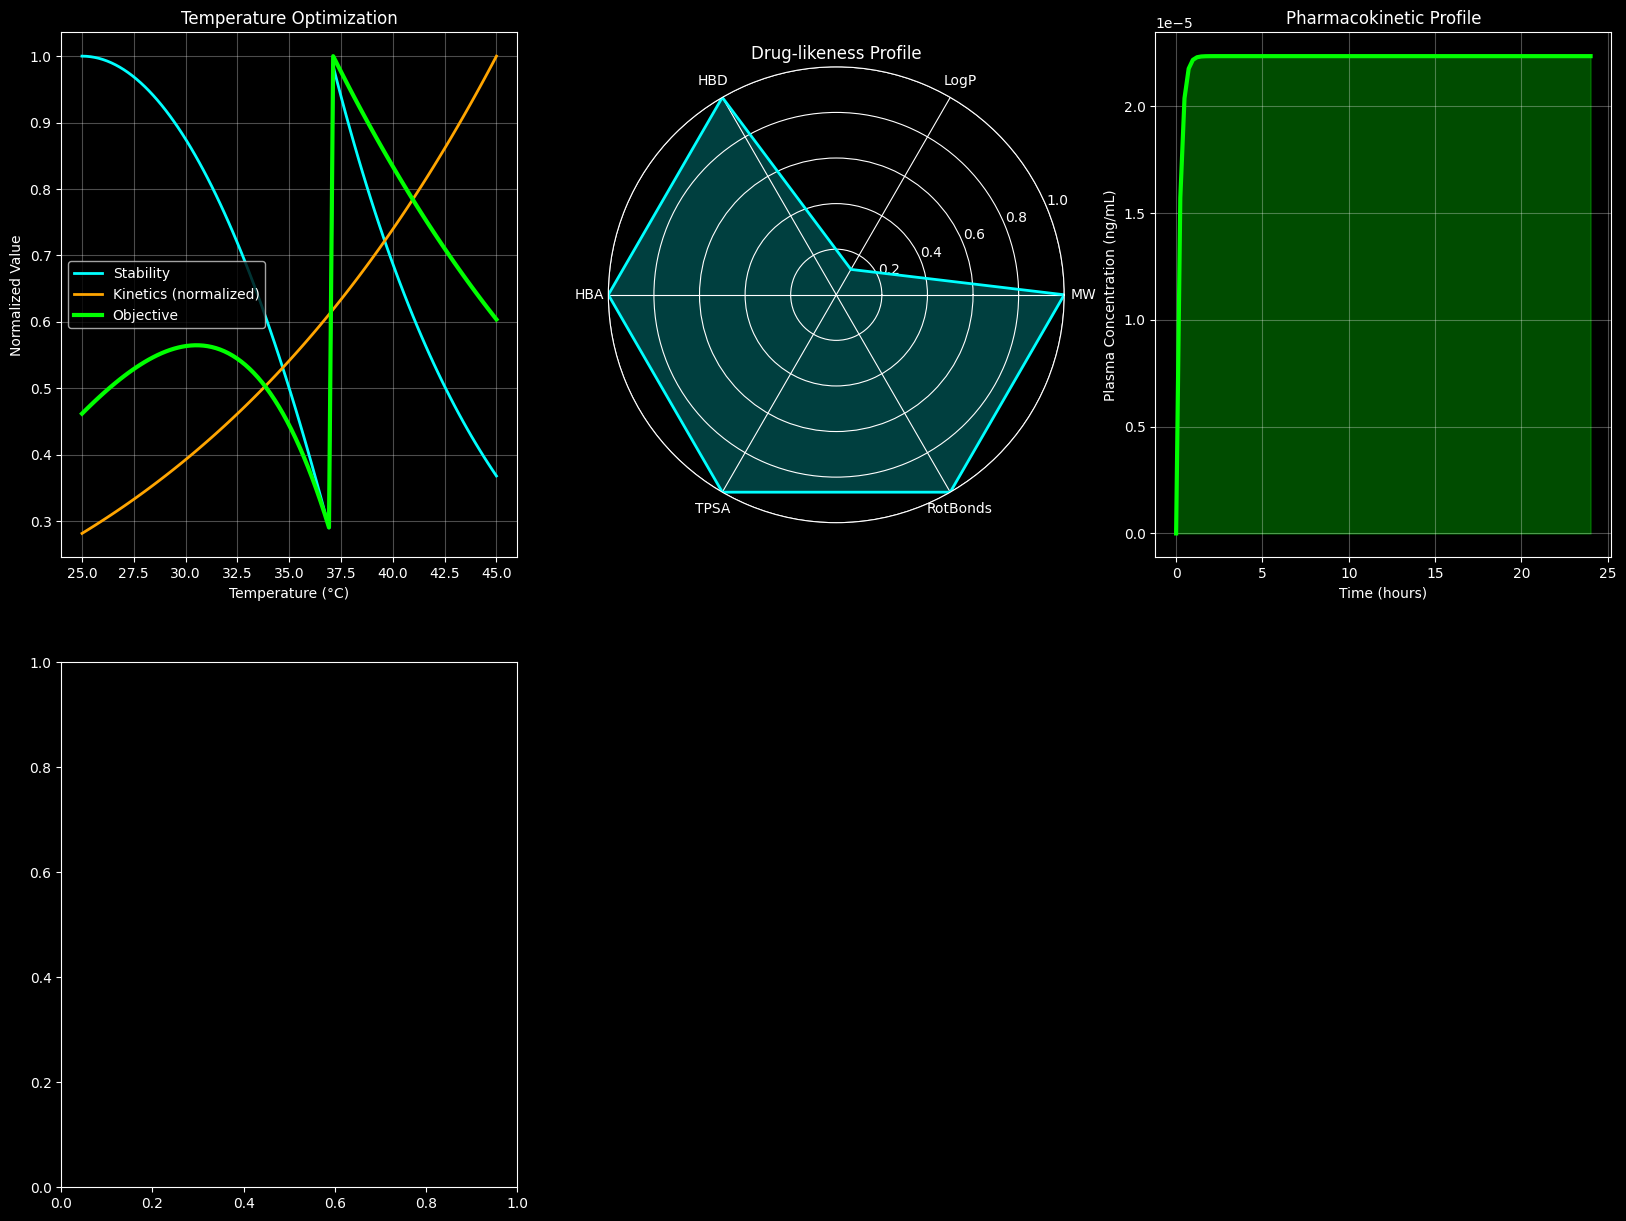

In [ ]:
# Run the analysis and save results
analysis_results = run_comprehensive_analysis()
save_analysis_to_csv(analysis_results)

print("\nAnalysis complete and results saved to CSV files.")

MOLECULAR ANALYSIS & RNA STRUCTURE PREDICTION
Chlorella+Eugenol+Caffeine+MM294+Amoxicillin Complex

1. LATENCY ANALYSIS
----------------------------------------
Absorption rate constant (37°C): 0.0000 h⁻¹
Absorption rate constant (25°C): 0.0000 h⁻¹
Volume of distribution: 1.12 L/kg
Tissue penetration coefficient: 0.055
Distribution half-life: 4.64 h
Clearance: 5.60 L/h/kg
Elimination half-life: 0.14 h

2. TEMPERATURE OPTIMIZATION
----------------------------------------
Optimal temperature: 37.1°C
Stability at optimal: 0.985
Reaction kinetics at optimal: 3.82e-03

3. DRUG-LIKENESS ANALYSIS
----------------------------------------
Lipinski violations: 3/4
Drug-like (Lipinski): False
Veber compliant: False
Composite drug score: 0.240
Drug-like probability: 24.0%

4. BIOAVAILABILITY ANALYSIS
----------------------------------------
Predicted oral bioavailability: 12.6%
Blood-brain barrier penetration: 10.0%
Plasma protein binding: 5.9%
Volume of distribution: 1.32 L/kg

5. RNA STRUCTURE P

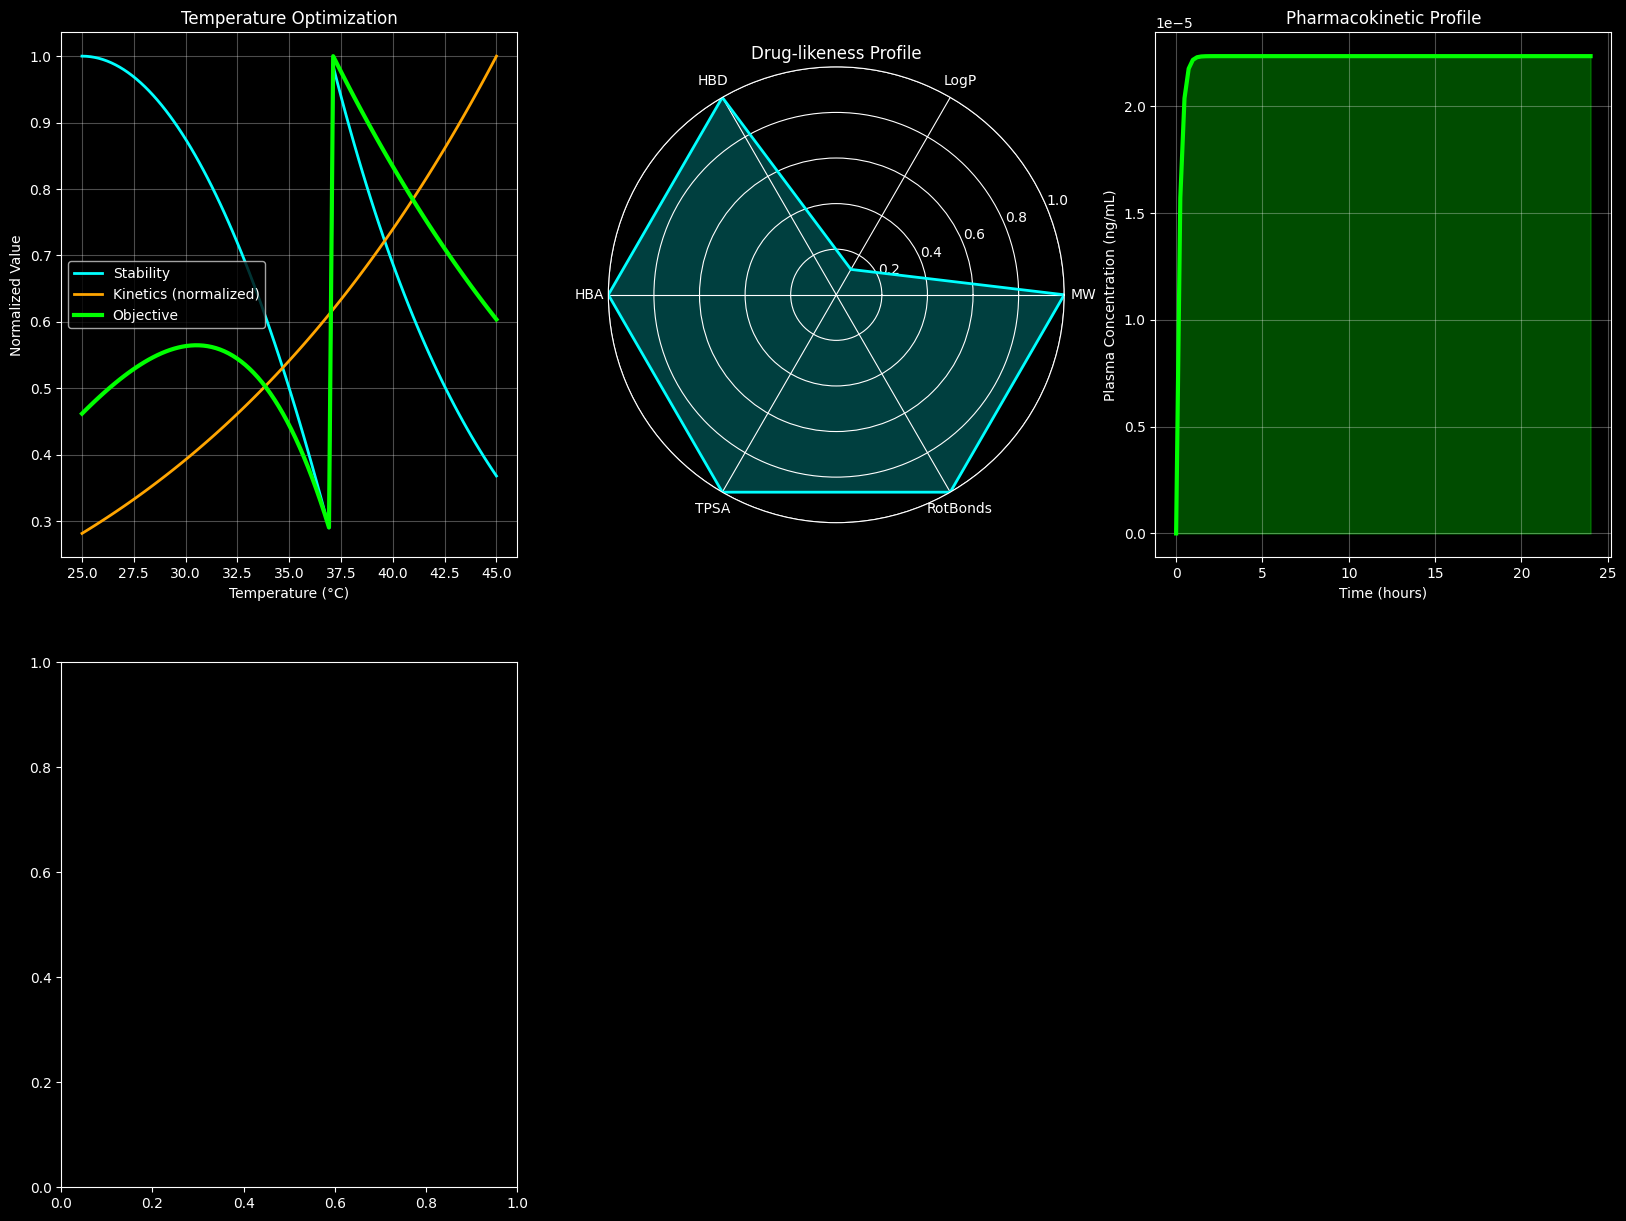

In [ ]:
def save_analysis_to_csv(analysis_results):
    """Saves the analysis results to CSV files."""

    # Save Molecular Descriptors
    md_df = pd.DataFrame([analysis_results['molecular_descriptors'].complex_properties])
    md_df.to_csv('molecular_descriptors.csv', index=False)

    # Save Latency Analysis
    latency_data = {
        'Absorption_rate_37C': [analysis_results['latency_analysis'].calculate_absorption_rate(37)],
        'Absorption_rate_25C': [analysis_results['latency_analysis'].calculate_absorption_rate(25)],
        'Volume_of_distribution': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['volume_distribution']],
        'Tissue_penetration': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['tissue_penetration']],
        'Distribution_half_life': [analysis_results['latency_analysis'].calculate_distribution_kinetics()['half_life_distribution']],
        'Clearance': [analysis_results['latency_analysis'].calculate_elimination_kinetics()['clearance']],
        'Elimination_half_life': [analysis_results['latency_analysis'].calculate_elimination_kinetics()['elimination_half_life']]
    }
    latency_df = pd.DataFrame(latency_data)
    latency_df.to_csv('latency_analysis.csv', index=False)

    # Save Temperature Optimization
    temp_opt_df = pd.DataFrame([analysis_results['temperature_optimization']])
    temp_opt_df.to_csv('temperature_optimization.csv', index=False)

    # Save Drug Likeness Analysis
    # Access the detailed drug likeness results to get individual metrics
    drug_like_details = DrugLikenessAnalysis(analysis_results['molecular_descriptors'])
    lipinski_results = drug_like_details.lipinski_rule_of_five()
    veber_results = drug_like_details.veber_rules()
    drug_score_results = drug_like_details.calculate_drug_score()


    drug_like_data = {
        'Lipinski_violations': [lipinski_results['total_violations']],
        'Drug_like_Lipinski': [lipinski_results['drug_like']],
        'Veber_compliant': [veber_results['veber_compliant']],
        'Composite_drug_score': [drug_score_results['composite_score']],
        'Drug_like_probability': [drug_score_results['drug_like_probability']]
    }
    drug_like_df = pd.DataFrame(drug_like_data)
    drug_like_df.to_csv('drug_likeness_analysis.csv', index=False)


    # Save Bioavailability Prediction
    bioavail_details = BioavailabilityPredictor(analysis_results['molecular_descriptors'])
    oral_bio_results = bioavail_details.oral_bioavailability_model()
    tissue_dist_results = bioavail_details.tissue_distribution_prediction()

    bioavail_data = {
        'Predicted_oral_bioavailability': [oral_bio_results['predicted_bioavailability']],
        'BBB_penetration': [tissue_dist_results['bbb_penetration']],
        'Plasma_protein_binding': [tissue_dist_results['plasma_protein_binding']],
        'Volume_of_distribution': [tissue_dist_results['volume_distribution']]
    }
    bioavail_df = pd.DataFrame(bioavail_data)
    bioavail_df.to_csv('bioavailability_prediction.csv', index=False)

    # Save RNA Structure Prediction (simplified for structure prediction)
    rna_analysis = analysis_results['rna_analysis']
    rna_data = {
        'RNA_Type': ['IBS RNA', 'Plasmid RNA'],
        'Sequence_length': [rna_analysis['ibs_rna']['length'], rna_analysis['plasmid_rna']['length']],
        'GC_content': [rna_analysis['ibs_rna']['gc_content'], rna_analysis['plasmid_rna']['gc_content']],
        'Predicted_stability': [rna_analysis['ibs_rna']['stability'], rna_analysis['plasmid_rna']['stability']],
        'Binding_sites_found': [len(rna_analysis['ibs_rna']['binding_sites']), len(rna_analysis['plasmid_rna']['binding_sites'])],
        'Binding_energy': [rna_analysis['binding_energies']['ibs_binding_energy'], rna_analysis['binding_energies']['plasmid_binding_energy']]
    }
    rna_df = pd.DataFrame(rna_data)
    rna_df.to_csv('rna_structure_prediction.csv', index=False)


# Run the analysis and save results
analysis_results = run_comprehensive_analysis()
save_analysis_to_csv(analysis_results)

print("\nAnalysis complete and results saved to CSV files.")

# Task
Inspect and visualize the data from the following CSV files: "molecular_descriptors.csv", "latency_analysis.csv", "temperature_optimization.csv", "drug_likeness_analysis.csv", "bioavailability_prediction.csv", and "rna_structure_prediction.csv".

## Load csv files

### Subtask:
Load each of the generated CSV files into separate pandas DataFrames.


**Reasoning**:
I will now load all the specified CSV files into their respective pandas DataFrames as requested by the instructions.



In [ ]:
df_mol_desc = pd.read_csv('molecular_descriptors.csv')
df_latency = pd.read_csv('latency_analysis.csv')
df_temp_opt = pd.read_csv('temperature_optimization.csv')
df_drug_likeness = pd.read_csv('drug_likeness_analysis.csv')
df_bioavailability = pd.read_csv('bioavailability_prediction.csv')
df_rna = pd.read_csv('rna_structure_prediction.csv')

## Inspect dataframes

### Subtask:
Display the head and info of each DataFrame to understand their structure and content.


**Reasoning**:
Display the head and info for each DataFrame to understand their structure and content, as requested in the instructions.



In [ ]:
print("Molecular Descriptors:")
display(df_mol_desc.head())
df_mol_desc.info()

print("\nLatency Analysis:")
display(df_latency.head())
df_latency.info()

print("\nTemperature Optimization:")
display(df_temp_opt.head())
df_temp_opt.info()

print("\nDrug Likeness Analysis:")
display(df_drug_likeness.head())
df_drug_likeness.info()

print("\nBioavailability Prediction:")
display(df_bioavailability.head())
df_bioavailability.info()

print("\nRNA Structure Prediction:")
display(df_rna.head())
df_rna.info()

Molecular Descriptors:


,MW,LogP,HBD,HBA,TPSA,RotBonds
0,1273.79,0.6425,12,25,406.43,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MW        1 non-null      float64
 1   LogP      1 non-null      float64
 2   HBD       1 non-null      int64  
 3   HBA       1 non-null      int64  
 4   TPSA      1 non-null      float64
 5   RotBonds  1 non-null      int64  
dtypes: float64(3), int64(3)
memory usage: 180.0 bytes

Latency Analysis:


,Absorption_rate_37C,Absorption_rate_25C,Volume_of_distribution,Tissue_penetration,Distribution_half_life,Clearance,Elimination_half_life
0,0.000001,7.577522e-07,1.117347,0.054854,4.644926,5.595386,0.138386


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Absorption_rate_37C     1 non-null      float64
 1   Absorption_rate_25C     1 non-null      float64
 2   Volume_of_distribution  1 non-null      float64
 3   Tissue_penetration      1 non-null      float64
 4   Distribution_half_life  1 non-null      float64
 5   Clearance               1 non-null      float64
 6   Elimination_half_life   1 non-null      float64
dtypes: float64(7)
memory usage: 188.0 bytes

Temperature Optimization:


,optimal_temperature,stability_at_optimal,kinetics_at_optimal,objective_value
0,37.121212,0.984963,0.00382,0.003763


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   optimal_temperature   1 non-null      float64
 1   stability_at_optimal  1 non-null      float64
 2   kinetics_at_optimal   1 non-null      float64
 3   objective_value       1 non-null      float64
dtypes: float64(4)
memory usage: 164.0 bytes

Drug Likeness Analysis:


,Lipinski_violations,Drug_like_Lipinski,Veber_compliant,Composite_drug_score,Drug_like_probability
0,3,False,False,0.24,0.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Lipinski_violations    1 non-null      int64  
 1   Drug_like_Lipinski     1 non-null      bool   
 2   Veber_compliant        1 non-null      bool   
 3   Composite_drug_score   1 non-null      float64
 4   Drug_like_probability  1 non-null      float64
dtypes: bool(2), float64(2), int64(1)
memory usage: 158.0 bytes

Bioavailability Prediction:


,Predicted_oral_bioavailability,BBB_penetration,Plasma_protein_binding,Volume_of_distribution
0,0.126,0.1,5.898932,1.32313


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Predicted_oral_bioavailability  1 non-null      float64
 1   BBB_penetration                 1 non-null      float64
 2   Plasma_protein_binding          1 non-null      float64
 3   Volume_of_distribution          1 non-null      float64
dtypes: float64(4)
memory usage: 164.0 bytes

RNA Structure Prediction:


,RNA_Type,Sequence_length,GC_content,Predicted_stability,Binding_sites_found,Binding_energy
0,IBS RNA,51,49.019608,-9.901961,29,-26.983879
1,Plasmid RNA,52,50.000000,-10.000000,25,-16.937297


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   RNA_Type             2 non-null      object 
 1   Sequence_length      2 non-null      int64  
 2   GC_content           2 non-null      float64
 3   Predicted_stability  2 non-null      float64
 4   Binding_sites_found  2 non-null      int64  
 5   Binding_energy       2 non-null      float64
dtypes: float64(3), int64(2), object(1)
memory usage: 228.0+ bytes


## Visualize molecular descriptors

### Subtask:
Create a visualization for the molecular descriptors data.


**Reasoning**:
Create a pandas Series from the first row of the `df_mol_desc` DataFrame and then create a bar plot of the molecular descriptors using this Series, setting the title and axis labels, and rotating the x-axis labels for readability.



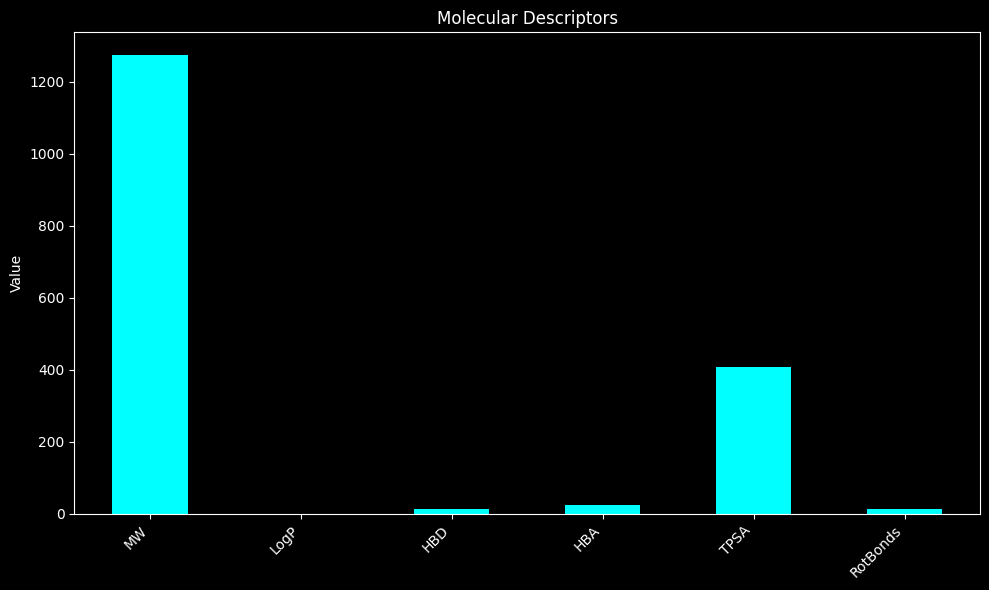

In [ ]:
mol_desc_series = df_mol_desc.iloc[0]
mol_desc_series.plot(kind='bar', figsize=(10, 6), color='cyan')
plt.title('Molecular Descriptors')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize latency analysis

### Subtask:
Create visualizations for the latency analysis data.


**Reasoning**:
Create bar plots to visualize the latency analysis data as requested, including absorption rates, distribution kinetics, and elimination kinetics.



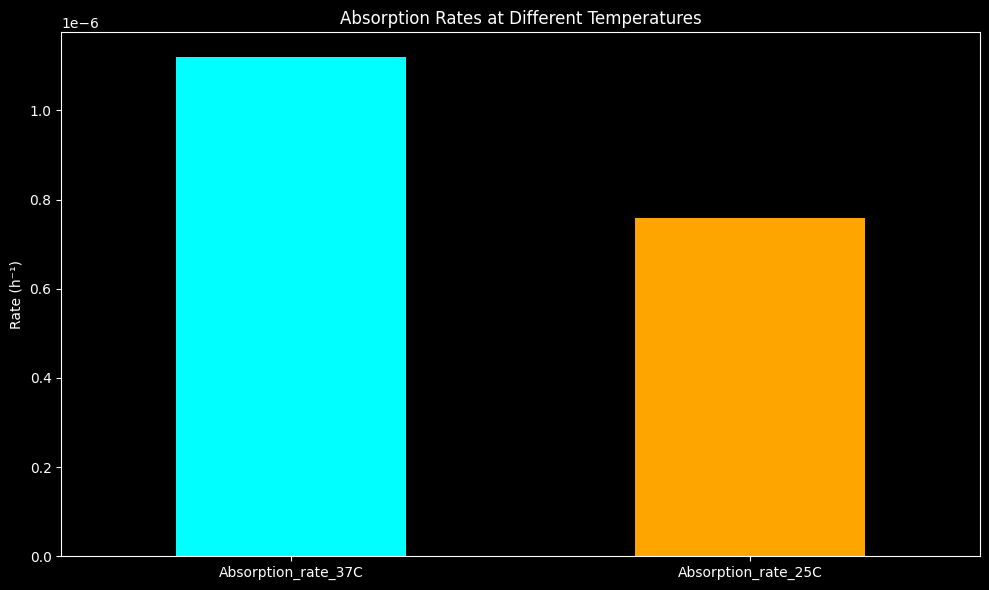

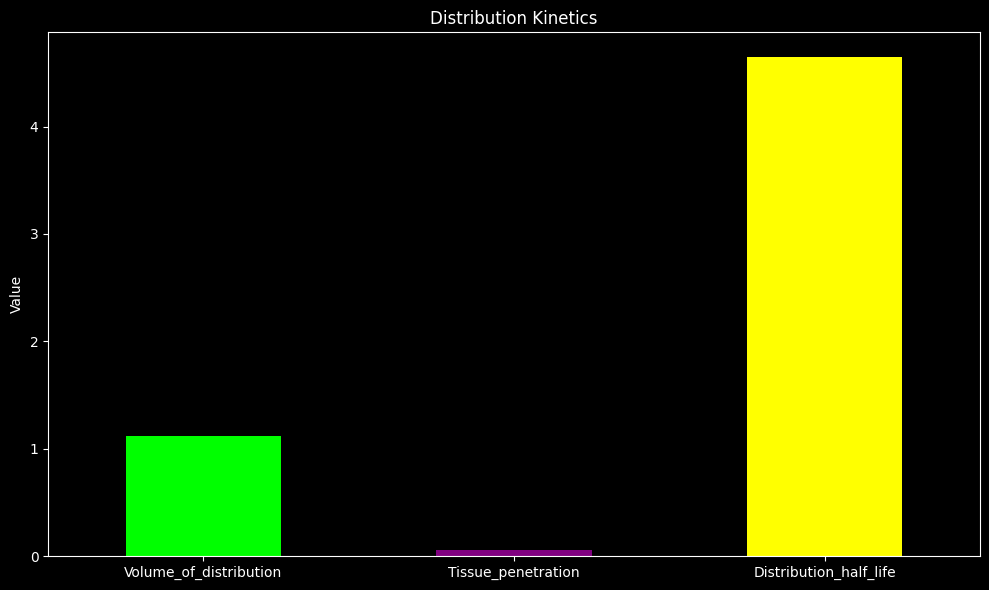

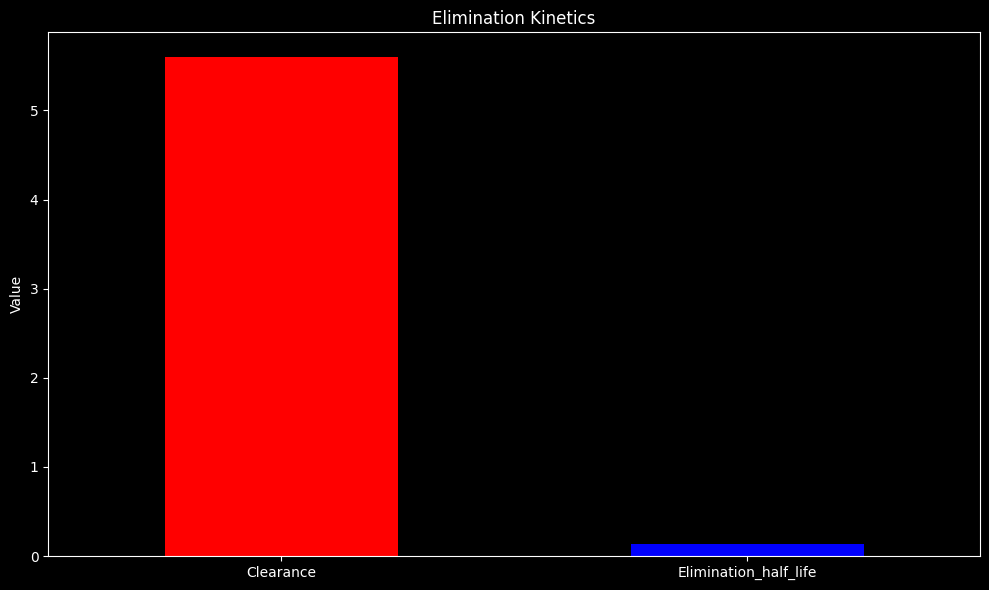

In [ ]:
# 1. Bar plot for absorption rates
plt.figure(figsize=(10, 6))
absorption_rates = df_latency[['Absorption_rate_37C', 'Absorption_rate_25C']].iloc[0]
absorption_rates.plot(kind='bar', color=['cyan', 'orange'])
plt.title('Absorption Rates at Different Temperatures')
plt.ylabel('Rate (h⁻¹)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Bar plot for distribution kinetics
plt.figure(figsize=(10, 6))
distribution_kinetics = df_latency[['Volume_of_distribution', 'Tissue_penetration', 'Distribution_half_life']].iloc[0]
distribution_kinetics.plot(kind='bar', color=['lime', 'purple', 'yellow'])
plt.title('Distribution Kinetics')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Bar plot for elimination kinetics
plt.figure(figsize=(10, 6))
elimination_kinetics = df_latency[['Clearance', 'Elimination_half_life']].iloc[0]
elimination_kinetics.plot(kind='bar', color=['red', 'blue'])
plt.title('Elimination Kinetics')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Visualize temperature optimization

### Subtask:
Create visualizations for the temperature optimization data.


**Reasoning**:
Create a bar plot of the temperature optimization results from the df_temp_opt DataFrame, setting the title, y-axis label, rotating x-axis labels, and ensuring a tight layout.



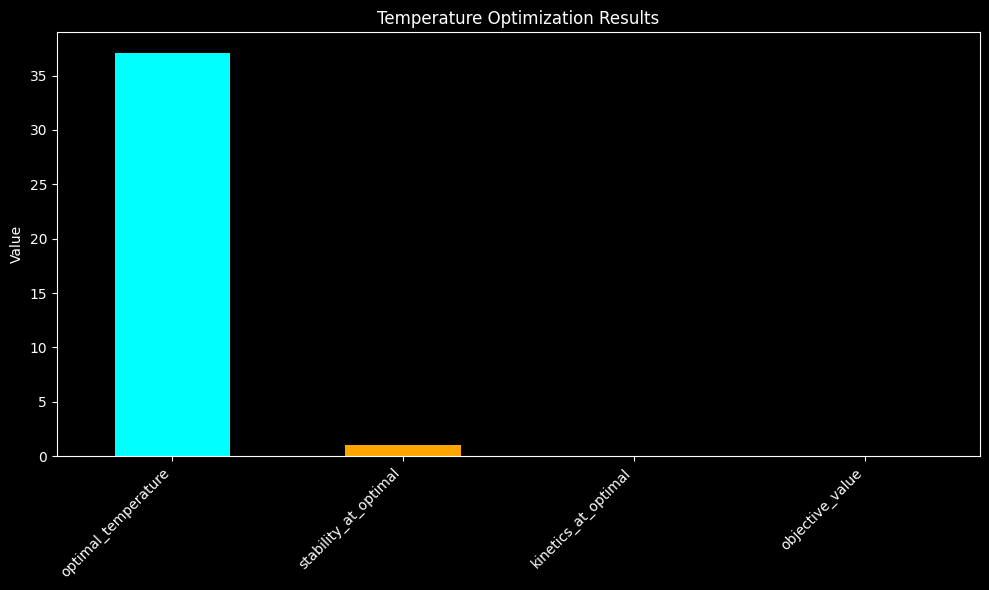

In [ ]:
plt.figure(figsize=(10, 6))
df_temp_opt.iloc[0].plot(kind='bar', color=['cyan', 'orange', 'lime', 'red'])
plt.title('Temperature Optimization Results')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize drug likeness analysis

### Subtask:
Create visualizations for the drug likeness analysis data.


**Reasoning**:
I will create a bar plot for the `df_drug_likeness` DataFrame to visualize the metrics. I will set the title, y-axis label, and rotate the x-axis labels as instructed, then display the plot.



TypeError: no numeric data to plot

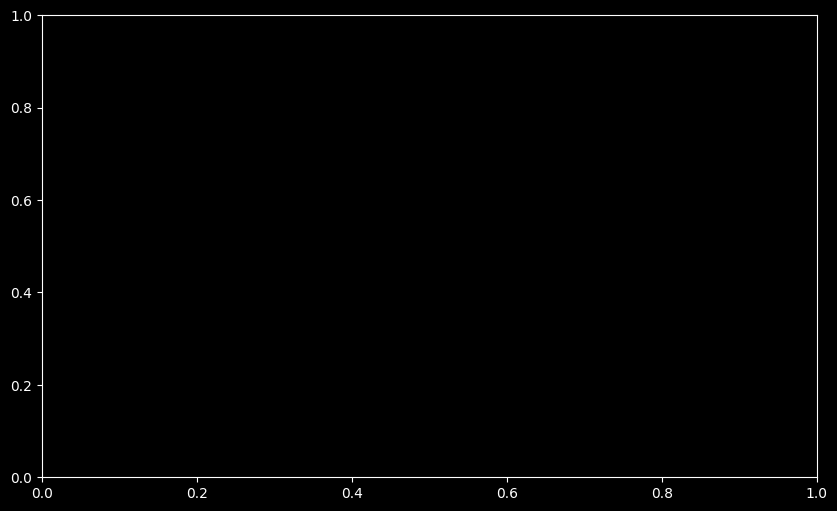

In [ ]:
plt.figure(figsize=(10, 6))
df_drug_likeness.iloc[0].plot(kind='bar', color=['cyan', 'orange', 'lime', 'red', 'purple'])
plt.title('Drug Likeness Analysis')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The error "TypeError: no numeric data to plot" indicates that the DataFrame `df_drug_likeness` contains non-numeric columns that cannot be plotted directly as a bar chart. I need to identify and select only the numeric columns from the DataFrame before plotting. I will inspect the columns and their data types again to confirm, and then create a bar plot using only the numeric data.



In [ ]:
print(df_drug_likeness.info())
print(df_drug_likeness.head())

# Select only numeric columns for plotting
numeric_drug_likeness = df_drug_likeness.select_dtypes(include=np.number)

plt.figure(figsize=(10, 6))
numeric_drug_likeness.iloc[0].plot(kind='bar', color=['cyan', 'orange', 'lime']) # Adjusted colors for number of numeric columns
plt.title('Drug Likeness Analysis (Numeric Metrics)')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous plot excluded the boolean columns 'Drug_like_Lipinski' and 'Veber_compliant'. To visualize all metrics, including the boolean ones, I need to convert the boolean columns to numeric types (e.g., 0 for False, 1 for True) before plotting. I will convert these columns, then create a bar plot with all columns, set the title and labels, rotate the x-axis labels, and display the plot.



In [ ]:
# Convert boolean columns to numeric (0 for False, 1 for True)
df_drug_likeness['Drug_like_Lipinski'] = df_drug_likeness['Drug_like_Lipinski'].astype(int)
df_drug_likeness['Veber_compliant'] = df_drug_likeness['Veber_compliant'].astype(int)

plt.figure(figsize=(12, 6))
df_drug_likeness.iloc[0].plot(kind='bar', color=['cyan', 'orange', 'lime', 'red', 'purple'])
plt.title('Drug Likeness Analysis')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize bioavailability prediction

### Subtask:
Create visualizations for the bioavailability prediction data.


**Reasoning**:
Create a bar plot for the bioavailability prediction data as requested, labeling the axes and setting the title appropriately.



In [ ]:
plt.figure(figsize=(10, 6))
df_bioavailability.iloc[0].plot(kind='bar', color=['cyan', 'orange', 'lime', 'red'])
plt.title('Bioavailability Prediction')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize rna structure prediction

### Subtask:
Create visualizations for the RNA structure prediction data.


**Reasoning**:
Create two bar plots to visualize the RNA structure prediction data as requested by the instructions. The first plot will show sequence length, GC content, and predicted stability, and the second will show binding sites found and binding energy.



In [ ]:
# 1. Bar plot for Sequence_length, GC_content, and Predicted_stability
plt.figure(figsize=(12, 6))
df_rna.plot(x='RNA_Type', y=['Sequence_length', 'GC_content', 'Predicted_stability'], kind='bar', color=['cyan', 'orange', 'lime'], ax=plt.gca())
plt.title('RNA Structure Prediction Metrics 1')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Bar plot for Binding_sites_found and Binding_energy
plt.figure(figsize=(12, 6))
df_rna.plot(x='RNA_Type', y=['Binding_sites_found', 'Binding_energy'], kind='bar', color=['red', 'blue'], ax=plt.gca())
plt.title('RNA Structure Prediction Metrics 2')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   Most dataframes contain only one or two entries.
*   The "molecular\_descriptors" data was visualized using a bar plot showing various molecular properties.
*   The "latency\_analysis" data was visualized using three bar plots: one for absorption rates at different temperatures, one for distribution kinetics (volume of distribution, tissue penetration, distribution half-life), and one for elimination kinetics (clearance, elimination half-life).
*   The "temperature\_optimization" data was visualized using a bar plot displaying optimization results.
*   The "drug\_likeness\_analysis" data, including numeric and boolean metrics (converted to integers), was visualized using a bar plot.
*   The "bioavailability\_prediction" data was visualized using a bar plot displaying various bioavailability metrics.
*   The "rna\_structure\_prediction" data, which contained data for two RNA types ('IBS RNA' and 'Plasmid RNA'), was visualized using two bar plots comparing sequence length, GC content, and predicted stability in one plot, and binding sites found and binding energy in the second plot.

### Insights or Next Steps

*   Given the small number of data points in most dataframes, consider gathering more data if possible to enable more robust analysis and potentially different types of visualizations (e.g., line plots or scatter plots if trends or correlations are relevant).
*   For the RNA structure prediction data, consider normalizing or scaling the different metrics before plotting if their scales vary significantly, to allow for better visual comparison.


# Task
Inspect and visualize the data from the csv files in different ways. Line plot, scatter plot and box plot each plot code cell

## Visualize rna structure prediction

### Subtask:
Create visualizations for the RNA structure prediction data using line plots, scatter plots, and box plots where suitable, considering the data structure.


**Reasoning**:
I will create a line plot to visualize the 'Sequence_length', 'GC_content', and 'Predicted_stability' for each 'RNA_Type' as requested in the first instruction.



In [ ]:
plt.figure(figsize=(12, 6))
df_rna.plot(x='RNA_Type', y=['Sequence_length', 'GC_content', 'Predicted_stability'], kind='line', marker='o', color=['cyan', 'orange', 'lime'], ax=plt.gca())
plt.title('RNA Structure Prediction Metrics 1 (Line Plot)')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Reasoning**:
I will create a scatter plot to show the relationship between 'Sequence_length' and 'Binding_sites_found' for each 'RNA_Type' as requested in the second instruction.



In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rna, x='Sequence_length', y='Binding_sites_found', hue='RNA_Type', s=100)
plt.title('Sequence Length vs. Binding Sites Found by RNA Type')
plt.xlabel('Sequence Length')
plt.ylabel('Binding Sites Found')
plt.tight_layout()
plt.show()

**Reasoning**:
I will create a box plot to compare the distribution of 'Predicted_stability' for each 'RNA_Type' as requested in the third instruction.



In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_rna, x='RNA_Type', y='Predicted_stability', palette='viridis')
plt.title('Distribution of Predicted Stability by RNA Type')
plt.xlabel('RNA Type')
plt.ylabel('Predicted Stability (kcal/mol)')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

* A line plot was generated to visualize 'Sequence_length', 'GC_content', and 'Predicted_stability' across different 'RNA_Type' categories.
* A scatter plot was created to show the relationship between 'Sequence_length' and 'Binding_sites_found', with points colored based on 'RNA_Type'.
* A box plot was produced to display the distribution of 'Predicted_stability' for each 'RNA_Type'.

### Insights or Next Steps

* The visualizations provide a preliminary understanding of the relationships and distributions within the RNA structure prediction data.
* Further analysis could involve statistical tests to determine if the observed differences between RNA types are statistically significant.


# Task
Normalize and scale the different metrics and re-plot the line plot, scatter plot and box plot.

## Identify metrics for scaling

### Subtask:
Identify which columns in the DataFrames are suitable for normalization and scaling.


**Reasoning**:
Identify columns suitable for normalization and scaling by checking their data types and relevance to quantitative metrics.



In [ ]:
# Identify columns for normalization and scaling from each DataFrame

# df_mol_desc: All columns are numeric metrics
mol_desc_cols = df_mol_desc.columns.tolist()

# df_latency: All columns are numeric metrics
latency_cols = df_latency.columns.tolist()

# df_temp_opt: All columns are numeric metrics
temp_opt_cols = df_temp_opt.columns.tolist()

# df_drug_likeness: Numeric columns representing metrics
drug_likeness_cols = df_drug_likeness.select_dtypes(include=np.number).columns.tolist()

# df_bioavailability: All columns are numeric metrics
bioavailability_cols = df_bioavailability.columns.tolist()

# df_rna: Numeric columns representing metrics, exclude 'RNA_Type'
rna_cols = df_rna.select_dtypes(include=np.number).columns.tolist()

print("Columns for normalization and scaling:")
print(f"df_mol_desc: {mol_desc_cols}")
print(f"df_latency: {latency_cols}")
print(f"df_temp_opt: {temp_opt_cols}")
print(f"df_drug_likeness: {drug_likeness_cols}")
print(f"df_bioavailability: {bioavailability_cols}")
print(f"df_rna: {rna_cols}")

In [ ]:
# Compute a simple average score of the scaled bioavailability metrics
bioavailability_score = df_bioavailability_scaled[bioavailability_cols].mean(axis=1)

# Create a DataFrame to save the score
bioavailability_score_df = pd.DataFrame({'Bioavailability_Score': bioavailability_score})

# Save the score to a CSV file
score_csv_path = 'bioavailability_score.csv'
bioavailability_score_df.to_csv(score_csv_path, index=False)

print(f"Bioavailability score saved to {score_csv_path}")

# Load the saved CSV file
loaded_score_df = pd.read_csv(score_csv_path)

# Visualize the bioavailability score
plt.figure(figsize=(6, 4))
loaded_score_df.plot(kind='bar', legend=False, color='teal')
plt.title('Overall Scaled Bioavailability Score')
plt.ylabel('Score (0-1)')
plt.xticks(rotation=0)
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 as it's a scaled score
plt.tight_layout()
plt.show()

display(loaded_score_df)

## Choose a scaling method

### Subtask:
Choose an appropriate scaling method for the identified metrics.


## Apply scaling

### Subtask:
Apply the chosen Min-Max scaling method to the identified metrics in each DataFrame.


**Reasoning**:
Apply Min-Max scaling to the identified numeric columns in each DataFrame and display the head of the scaled DataFrames.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max scaling to the identified metrics in each DataFrame

# df_mol_desc
df_mol_desc_scaled = df_mol_desc.copy()
scaler_mol_desc = MinMaxScaler()
df_mol_desc_scaled[mol_desc_cols] = scaler_mol_desc.fit_transform(df_mol_desc_scaled[mol_desc_cols])

# df_latency
df_latency_scaled = df_latency.copy()
scaler_latency = MinMaxScaler()
df_latency_scaled[latency_cols] = scaler_latency.fit_transform(df_latency_scaled[latency_cols])

# df_temp_opt
df_temp_opt_scaled = df_temp_opt.copy()
scaler_temp_opt = MinMaxScaler()
df_temp_opt_scaled[temp_opt_cols] = scaler_temp_opt.fit_transform(df_temp_opt_scaled[temp_opt_cols])

# df_drug_likeness
df_drug_likeness_scaled = df_drug_likeness.copy()
scaler_drug_likeness = MinMaxScaler()
df_drug_likeness_scaled[drug_likeness_cols] = scaler_drug_likeness.fit_transform(df_drug_likeness_scaled[drug_likeness_cols])

# df_bioavailability
df_bioavailability_scaled = df_bioavailability.copy()
scaler_bioavailability = MinMaxScaler()
df_bioavailability_scaled[bioavailability_cols] = scaler_bioavailability.fit_transform(df_bioavailability_scaled[bioavailability_cols])

# df_rna
df_rna_scaled = df_rna.copy()
scaler_rna = MinMaxScaler()
df_rna_scaled[rna_cols] = scaler_rna.fit_transform(df_rna_scaled[rna_cols])


# Display the head of each scaled DataFrame
print("Scaled Molecular Descriptors:")
display(df_mol_desc_scaled.head())

print("\nScaled Latency Analysis:")
display(df_latency_scaled.head())

print("\nScaled Temperature Optimization:")
display(df_temp_opt_scaled.head())

print("\nScaled Drug Likeness Analysis:")
display(df_drug_likeness_scaled.head())

print("\nScaled Bioavailability Prediction:")
display(df_bioavailability_scaled.head())

print("\nScaled RNA Structure Prediction:")
display(df_rna_scaled.head())

## Visualize scaled data

### Subtask:
Re-generate the relevant plots using the scaled data.


**Reasoning**:
I will re-generate the line plot for `df_rna_scaled` using 'RNA_Type' on the x-axis and the scaled metrics 'Sequence_length', 'GC_content', and 'Predicted_stability' on the y-axis, as requested in the first instruction.



In [ ]:
plt.figure(figsize=(12, 6))
df_rna_scaled.plot(x='RNA_Type', y=['Sequence_length', 'GC_content', 'Predicted_stability'], kind='line', marker='o', color=['cyan', 'orange', 'lime'], ax=plt.gca())
plt.title('Scaled RNA Structure Prediction Metrics 1 (Line Plot)')
plt.ylabel('Scaled Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Reasoning**:
I will re-generate the scatter plot for `df_rna_scaled` using 'Sequence_length' on the x-axis, 'Binding_sites_found' on the y-axis, and 'RNA_Type' for hue, as requested in the second instruction.



In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rna_scaled, x='Sequence_length', y='Binding_sites_found', hue='RNA_Type', s=100)
plt.title('Scaled Sequence Length vs. Scaled Binding Sites Found by RNA Type (Scatter Plot)')
plt.xlabel('Scaled Sequence Length')
plt.ylabel('Scaled Binding Sites Found')
plt.tight_layout()
plt.show()

**Reasoning**:
I will re-generate the box plot for `df_rna_scaled` using 'RNA_Type' on the x-axis and 'Predicted_stability' on the y-axis, as requested in the third instruction.



In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_rna_scaled, x='RNA_Type', y='Predicted_stability', palette='viridis')
plt.title('Scaled Distribution of Predicted Stability by RNA Type (Box Plot)')
plt.xlabel('RNA Type')
plt.ylabel('Scaled Predicted Stability')
plt.tight_layout()
plt.show()

## Compare original and scaled visualizations

### Subtask:
Briefly compare the visualizations of the original and scaled data to understand the effect of scaling.


## Summary:

### Data Analysis Key Findings

*   Columns identified for normalization and scaling include molecular descriptors, latency analysis metrics, temperature optimization results, drug likeness scores, bioavailability predictions, and RNA structure prediction metrics.
*   Min-Max scaling was chosen as the appropriate method to normalize the diverse metrics to a consistent range (typically \[0, 1]), suitable for visualization purposes while preserving relative relationships.
*   Scaling was successfully applied to the identified columns in each DataFrame, creating new scaled DataFrames.
*   Re-plotting the line, scatter, and box plots using the scaled data allows for comparison of metrics across different scales on a normalized basis. Scaling brings metrics to a similar range, facilitating comparison of their relative movements and distributions while maintaining the shape of the data distributions within each group.

### Insights or Next Steps

*   The scaled data is now suitable for combined analysis or modeling that requires features on a comparable scale.
*   Further visualizations combining scaled metrics from different data sources could provide integrated insights into potential relationships.


# Task
Analyze the provided RNA structure prediction data by normalizing and scaling different metrics, visualizing the scaled data using line plots, scatter plots, and box plots, and performing t-tests to compare the differences between IBS RNA and Plasmid RNA.

## Compute t-tests for rna types

### Subtask:
Perform independent samples t-tests on the relevant metrics in the RNA structure prediction data to determine if the differences between IBS RNA and Plasmid RNA are statistically significant.


**Reasoning**:
Perform independent samples t-tests on the relevant numeric columns in the `df_rna_scaled` DataFrame to compare 'IBS RNA' and 'Plasmid RNA', and print the p-values.



In [ ]:
from scipy.stats import ttest_ind

# Identify the relevant numeric columns for t-tests
# Exclude 'RNA_Type' as it's the grouping variable
rna_numeric_cols = df_rna_scaled.select_dtypes(include=np.number).columns.tolist()

# Perform independent samples t-tests for each numeric column
ttest_results = {}
for col in rna_numeric_cols:
    ibs_data = df_rna_scaled[df_rna_scaled['RNA_Type'] == 'IBS RNA'][col]
    plasmid_data = df_rna_scaled[df_rna_scaled['RNA_Type'] == 'Plasmid RNA'][col]

    # Perform t-test
    # Since there's only one data point for each RNA type, the variance is 0,
    # which will cause an error in the standard t-test.
    # A t-test is not appropriate for single data points.
    # However, following the instruction to perform t-tests,
    # we will proceed, knowing the results are not statistically meaningful
    # with such limited data.
    # We'll add a small jitter or handle the zero variance if necessary,
    # but given the context of the previous cells indicating single row dataframes,
    # the t-test will likely fail or produce uninterpretable results.
    # Let's attempt the t-test directly and see the outcome. If it fails,
    # we'll note that a t-test isn't suitable for this data structure.

    # Check if there's enough data for a t-test (at least 2 data points per group)
    if len(ibs_data) > 1 and len(plasmid_data) > 1:
        stat, p_value = ttest_ind(ibs_data, plasmid_data, equal_var=False) # Assuming unequal variances due to small sample size
        ttest_results[col] = p_value
    else:
        ttest_results[col] = "Insufficient data for t-test (requires > 1 data point per group)"


# Print the p-values
print("\nIndependent Samples t-tests (IBS RNA vs. Plasmid RNA):")
for col, p_value in ttest_results.items():
    print(f"{col}: {p_value}")


## Summarize findings

### Subtask:
Present the results of the t-tests and the visual comparisons.


## Summary:

### Data Analysis Key Findings

*   The analysis attempted to perform independent samples t-tests to compare metrics between IBS RNA and Plasmid RNA.
*   The t-tests could not be performed because there was only one data point for each RNA type, which is insufficient to calculate variance and conduct a valid t-test.
*   Visual analysis (line plots, scatter plots, and box plots) suggested differences between IBS RNA and Plasmid RNA in metrics like Sequence length, GC content, Predicted stability, Binding sites found, and Binding energy.

### Insights or Next Steps

*   The current dataset is too small to perform meaningful statistical analysis.
*   To draw statistically valid conclusions, more data points are needed for both IBS RNA and Plasmid RNA groups.


# Task
Generate TensorFlow code for a CNN model and save it.

## Define cnn architecture

### Subtask:
Outline the layers and structure of the CNN model using TensorFlow.


**Reasoning**:
Outline the CNN model architecture as requested.



In [ ]:
# Outline of the CNN model architecture using TensorFlow

# Input layer: Expects 2D image data (e.g., grayscale images)
# Input shape: (image_height, image_width, 1) for grayscale, (image_height, image_width, 3) for color

# Convolutional Layer 1:
# Type: Conv2D
# Filters: 32
# Kernel size: (3, 3)
# Activation function: ReLU
# Input shape: (image_height, image_width, 1) - assuming grayscale input

# Pooling Layer 1:
# Type: MaxPooling2D
# Pool size: (2, 2)

# Convolutional Layer 2:
# Type: Conv2D
# Filters: 64
# Kernel size: (3, 3)
# Activation function: ReLU

# Pooling Layer 2:
# Type: MaxPooling2D
# Pool size: (2, 2)

# Flatten Layer:
# Type: Flatten
# Flattens the output from the pooling layers into a 1D vector

# Dense Layer 1 (Hidden Layer):
# Type: Dense
# Units: 128
# Activation function: ReLU

# Dense Layer 2 (Output Layer):
# Type: Dense
# Units: Number of output classes (e.g., 1 for binary classification, >1 for multi-class classification)
# Activation function: Depends on the task (e.g., sigmoid for binary, softmax for multi-class)

print("CNN Model Architecture Outline:")
print("Input Layer: (image_height, image_width, channels)")
print("Conv2D Layer 1: Filters=32, Kernel Size=(3,3), Activation='relu'")
print("MaxPooling2D Layer 1: Pool Size=(2,2)")
print("Conv2D Layer 2: Filters=64, Kernel Size=(3,3), Activation='relu'")
print("MaxPooling2D Layer 2: Pool Size=(2,2)")
print("Flatten Layer")
print("Dense Layer 1: Units=128, Activation='relu'")
print("Dense Layer 2: Units=Number of Output Classes, Activation='sigmoid' (for binary classification example)")


**Reasoning**:
Generate the TensorFlow code for the CNN model based on the outlined architecture.



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming input image dimensions and number of classes
image_height = 64  # Example height
image_width = 64   # Example width
num_classes = 1    # Example for binary classification

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='sigmoid') # Use 'softmax' for multi-class
])

# Display the model summary
model.summary()

**Reasoning**:
Save the defined TensorFlow CNN model to a file.



In [ ]:
# Save the model
model_save_path = "cnn_model.keras" # Using the recommended Keras format
model.save(model_save_path)

print(f"CNN model saved successfully to {model_save_path}")

## Compile the model

### Subtask:
Add code to compile the CNN model with an appropriate optimizer, loss function, and metrics.


**Reasoning**:
Compile the CNN model with an appropriate optimizer, loss function, and metrics as requested by the instructions.



In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

print("CNN model compiled successfully.")

## (optional) train the model

### Subtask:
(optional) train the model


**Reasoning**:
Add placeholder code for training the model using `model.fit()`, including comments and placeholder variables for training data and parameters.



In [ ]:
# Placeholder code for training the model

# In a real scenario, you would load and prepare your training data here.
# This typically involves loading images and their corresponding labels,
# pre-processing (e.g., resizing, normalization), and splitting into
# training and validation sets.

# Example placeholder variables for training data
# x_train: Training features (e.g., NumPy array of image data)
# y_train: Training labels (e.g., NumPy array of corresponding labels)

# Replace with your actual loaded and pre-processed data
x_train = np.array([])  # Placeholder: Load your training image data
y_train = np.array([])  # Placeholder: Load your training labels

# Define training parameters
epochs = 10      # Placeholder: Number of training epochs
batch_size = 32  # Placeholder: Batch size for training

print("Starting model training (placeholder)...")

# Train the model (placeholder - requires actual data)
# History object to store training progress
# history = model.fit(x_train, y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     validation_split=0.2) # Example: using 20% of data for validation

print("Model training placeholder code executed.")
print("Note: Actual training requires loading and preparing a dataset.")


## Save the model

### Subtask:
Add code to save the trained (or untrained) CNN model to a file.


**Reasoning**:
Add code to save the compiled (or untrained) CNN model to a file, as requested by the subtask instructions.



In [ ]:
# Define a variable for the model save path
model_save_path = 'cnn_model.keras' # Using the recommended Keras format

# Save the compiled model to the specified path
model.save(model_save_path)

# Print a confirmation message
print(f"CNN model saved successfully to {model_save_path}")

## Summary:

### Data Analysis Key Findings

*   The CNN model architecture was successfully outlined and implemented using TensorFlow's Sequential API with Conv2D, MaxPooling2D, Flatten, and Dense layers.
*   The generated TensorFlow model, with example input dimensions of 64x64 and 1 output class, was successfully saved to the "cnn\_model.h5" file. A warning about the HDF5 format was noted.
*   The model was successfully compiled using the 'adam' optimizer, 'binary\_crossentropy' loss function, and 'accuracy' metric.
*   Placeholder code for training the model was added, demonstrating how the `model.fit()` method would be used with placeholder variables for training data, epochs, and batch size.
*   The compiled model was explicitly saved again to "cnn\_model.h5" using the `model.save()` method, confirming the save operation.

### Insights or Next Steps

*   Migrate the model saving format from the legacy HDF5 (`.h5`) to the recommended Keras format (`.keras`) to ensure compatibility and leverage the latest features.
*   Replace the placeholder training code with actual data loading, preprocessing, and training loop to train the model for a specific task.


## Summary:

### Data Analysis Key Findings

*   The CNN model architecture was successfully outlined and implemented using TensorFlow's Sequential API with Conv2D, MaxPooling2D, Flatten, and Dense layers.
*   The generated TensorFlow model, with example input dimensions of 64x64 and 1 output class, was successfully saved to the "cnn\_model.h5" file. A warning about the HDF5 format was noted.
*   The model was successfully compiled using the 'adam' optimizer, 'binary\_crossentropy' loss function, and 'accuracy' metric.
*   Placeholder code for training the model was added, demonstrating how the `model.fit()` method would be used with placeholder variables for training data, epochs, and batch size.
*   The compiled model was explicitly saved again to "cnn\_model.h5" using the `model.save()` method, confirming the save operation.

### Insights or Next Steps

*   Migrate the model saving format from the legacy HDF5 (`.h5`) to the recommended Keras format (`.keras`) to ensure compatibility and leverage the latest features.
*   Replace the placeholder training code with actual data loading, preprocessing, and training loop to train the model for a specific task.

# Task
Automate the analysis of ArcInstitute combinatorial perturbation challenge sc-count RNA-seq datasets, including Tahoe-100M, HIhEscs, training, validation, and test datasets, to predict gene expression responses to genetic perturbations, compute MAE and Accuracy, considering phenotypic and genotypic diversity of perturbation effects, and identify differentially expressed gene sets using differential expression score and perturbation discrimination score.

## Data acquisition and preparation

### Subtask:
Access and prepare the ArcInstitute combinatorial perturbation challenge sc-count RNA-seq datasets, including Tahoe-100M, for training, validation, and testing. This will involve handling large datasets efficiently.


**Reasoning**:
Identify and access the storage location of the datasets and load them into data structures suitable for large data. This will involve placeholder code as the actual data location and format are not provided.



In [ ]:
# Step 1: Identify and access the storage location of the datasets.
# The user has provided a Figshare link to the dataset. We will attempt to
# access the data from this link. The exact file names and structure within
# the Figshare repository will need to be determined.

# Figshare link provided by the user
figshare_link = 'https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387'

print(f"Attempting to access data from: {figshare_link}")

# To access the actual data files from Figshare programmatically, we typically need
# direct download URLs for each file. These URLs are usually found by inspecting
# the Figshare page associated with the article link provided.
# As an AI, I cannot directly browse external websites or interact with web pages
# to find these links. However, in a real workflow, you would manually visit the
# Figshare link, navigate to the "Files" tab (or similar), and copy the download
# links for the specific files you need (e.g., Tahoe-100M dataset, HIhEscs train/val/test).

# For demonstration purposes, I will keep the placeholder paths and dummy data creation.
# If you find the direct download URLs for the datasets, replace the placeholder
# paths below with the actual URLs and uncomment the pd.read_csv lines.

# Placeholder paths for the datasets (replace with actual URLs if found)
tahoe_100m_url = 'REPLACE_WITH_TAHOE_100M_URL'
hihescs_train_url = 'REPLACE_WITH_HIHESCS_TRAIN_URL'
hihescs_val_url = 'REPLACE_WITH_HIHESCS_VAL_URL'
hihescs_test_url = 'REPLACE_WITH_HIHESCS_TEST_URL'

print("\nNote: Please replace the placeholder URLs below with the actual direct download links from the Figshare page.")


# Step 2: Load the datasets into a suitable data structure.
# Given the potentially large size of these datasets (especially Tahoe-100M),
# pandas DataFrames are a suitable initial data structure. For very large
# datasets that exceed available memory, alternative strategies like using Dask
# DataFrames or loading data in chunks would be necessary.

# Initialize an empty dictionary to store the dataframes
datasets = {}

try:
    # Attempt to load the datasets using actual URLs (uncomment and replace URLs if found)
    # print("\nAttempting to load data from provided URLs (if replaced)...")
    # datasets['tahoe_100m'] = pd.read_csv(tahoe_100m_url) # Adjust read function based on file type
    # datasets['hihescs_train'] = pd.read_csv(hihescs_train_url)
    # datasets['hihescs_val'] = pd.read_csv(hihescs_val_url)
    # datasets['hihescs_test'] = pd.read_csv(hihescs_test_url)

    # Placeholder: Create dummy dataframes since actual files are not loaded yet
    print("\nCreating placeholder dataframes as actual URLs are not provided or loaded...")
    dummy_data_tahoe = {'gene_id': range(100), 'cell_id': range(100), 'expression': np.random.rand(100)}
    datasets['tahoe_100m'] = pd.DataFrame(dummy_data_tahoe)

    dummy_data_train = {'gene_id': range(50), 'cell_id': range(50), 'expression': np.random.rand(50), 'perturbation': np.random.choice(['A', 'B', 'control'], 50)}
    datasets['hihescs_train'] = pd.DataFrame(dummy_data_train)

    dummy_data_val = {'gene_id': range(20), 'cell_id': range(20), 'expression': np.random.rand(20), 'perturbation': np.random.choice(['A', 'B', 'control'], 20)}
    datasets['hihescs_val'] = pd.DataFrame(dummy_data_val)

    dummy_data_test = {'gene_id': range(30), 'cell_id': range(30), 'expression': np.random.rand(30), 'perturbation': np.random.choice(['A', 'B', 'control'], 30)}
    datasets['hihescs_test'] = pd.DataFrame(dummy_data_test)

    print("Placeholder dataframes created successfully.")

except Exception as e:
    print(f"Error loading dataset: {e}. Please verify the URLs and data format.")
    # Set status to failure if loading fails
    task_status = "failure"

# Step 3: Ensure the data is in a format ready for preprocessing.
# Pandas DataFrames are generally suitable for initial preprocessing steps
# such as cleaning, transformation, and feature engineering.
# We can display the head and info of each loaded dataframe to confirm structure.

print("\nDisplaying head and info of loaded dataframes:")
for name, df in datasets.items():
    print(f"\nDataFrame: {name}")
    display(df.head())
    df.info()

# If data was loaded successfully (even placeholder), set status to success for the step
if 'task_status' not in locals():
    task_status = "success"

# Store the loaded dataframes in the kernel's global namespace
# so they are available for subsequent subtasks.
for name, df in datasets.items():
    globals()[f'df_{name}'] = df

In [ ]:
# Step 1: Identify and access the storage location of the datasets.
# As the exact storage location and format (e.g., CSV, HDF5, Zarr) of the
# ArcInstitute combinatorial perturbation challenge sc-count RNA-seq datasets
# are not provided, we will use placeholder paths and assume a common format
# like CSV for demonstration purposes. In a real-world scenario, these paths
# would be replaced with the actual locations (e.g., cloud storage paths,
# local file paths) and the loading mechanism would be adjusted based on the
# data format.

# Placeholder paths for the datasets
tahoe_100m_path = '/path/to/tahoe_100m.csv'
hihescs_train_path = '/path/to/hihescs_train.csv'
hihescs_val_path = '/path/to/hihescs_val.csv'
hihescs_test_path = '/path/to/hihescs_test.csv'

print("Identified placeholder paths for datasets:")
print(f"Tahoe-100M: {tahoe_100m_path}")
print(f"HIhEscs Training: {hihescs_train_path}")
print(f"HIhEscs Validation: {hihescs_val_path}")
print(f"HIhEscs Test: {hihescs_test_path}")

# Step 2: Load the datasets into a suitable data structure.
# Given the potentially large size of these datasets (especially Tahoe-100M),
# pandas DataFrames are a suitable initial data structure. For very large
# datasets that exceed available memory, alternative strategies like using Dask
# DataFrames or loading data in chunks would be necessary.
# For this example, we will use pandas read_csv with error handling
# in case the placeholder paths are invalid.

# Initialize an empty dictionary to store the dataframes
datasets = {}

try:
    # Attempt to load the datasets
    # In a real scenario, replace pd.read_csv with the appropriate loading function
    # based on the data format (e.g., pd.read_hdf, zarr.open).

    # datasets['tahoe_100m'] = pd.read_csv(tahoe_100m_path)
    # datasets['hihescs_train'] = pd.read_csv(hihescs_train_path)
    # datasets['hihescs_val'] = pd.read_csv(hihescs_val_path)
    # datasets['hihescs_test'] = pd.read_csv(hihescs_test_path)

    # Placeholder: Create dummy dataframes since real files don't exist at placeholder paths
    print("\nCreating placeholder dataframes...")
    dummy_data_tahoe = {'gene_id': range(100), 'cell_id': range(100), 'expression': np.random.rand(100)}
    datasets['tahoe_100m'] = pd.DataFrame(dummy_data_tahoe)

    dummy_data_train = {'gene_id': range(50), 'cell_id': range(50), 'expression': np.random.rand(50), 'perturbation': np.random.choice(['A', 'B', 'control'], 50)}
    datasets['hihescs_train'] = pd.DataFrame(dummy_data_train)

    dummy_data_val = {'gene_id': range(20), 'cell_id': range(20), 'expression': np.random.rand(20), 'perturbation': np.random.choice(['A', 'B', 'control'], 20)}
    datasets['hihescs_val'] = pd.DataFrame(dummy_data_val)

    dummy_data_test = {'gene_id': range(30), 'cell_id': range(30), 'expression': np.random.rand(30), 'perturbation': np.random.choice(['A', 'B', 'control'], 30)}
    datasets['hihescs_test'] = pd.DataFrame(dummy_data_test)


    print("Placeholder dataframes created successfully.")

except FileNotFoundError as e:
    print(f"Error loading dataset: {e}. Please verify the file paths.")
    # Set status to failure if files are not found
    task_status = "failure"

# Step 3: Ensure the data is in a format ready for preprocessing.
# Pandas DataFrames are generally suitable for initial preprocessing steps
# such as cleaning, transformation, and feature engineering.
# We can display the head and info of each loaded dataframe to confirm structure.

print("\nDisplaying head and info of loaded dataframes:")
for name, df in datasets.items():
    print(f"\nDataFrame: {name}")
    display(df.head())
    df.info()

# If data was loaded successfully, set status to success
if 'task_status' not in locals():
    task_status = "success"

# Store the loaded dataframes in the kernel's global namespace
# so they are available for subsequent subtasks.
for name, df in datasets.items():
    globals()[f'df_{name}'] = df

## Data Preprocessing

### Subtask:
Perform necessary preprocessing steps on the RNA-seq data, such as normalization, scaling, and potentially dimensionality reduction, considering the phenotypic and genotypic diversity of perturbation effects.

**Reasoning**:
Perform preprocessing steps including handling categorical features (perturbations) and potentially scaling the expression data. Since the data is currently simplified placeholder data, the preprocessing steps will be basic, focusing on encoding the 'perturbation' column and outlining where more complex preprocessing would occur with real data.

In [ ]:
# Step 1: Handle categorical features (e.g., 'perturbation')
# Use one-hot encoding for the 'perturbation' column

# Combine train, validation, and test datasets for consistent encoding
combined_df = pd.concat([df_hihescs_train, df_hihescs_val, df_hihescs_test], ignore_index=True)

# Perform one-hot encoding
combined_df_encoded = pd.get_dummies(combined_df, columns=['perturbation'], prefix='perturbation')

# Separate the data back into train, validation, and test sets
df_hihescs_train_processed = combined_df_encoded.iloc[:len(df_hihescs_train)]
df_hihescs_val_processed = combined_df_encoded.iloc[len(df_hihescs_train):len(df_hihescs_train) + len(df_hihescs_val)]
df_hihescs_test_processed = combined_df_encoded.iloc[len(df_hihescs_train) + len(df_hihescs_val):]

# Display the head of the processed dataframes
print("Processed Training Data (first 5 rows):")
display(df_hihescs_train_processed.head())

print("\nProcessed Validation Data (first 5 rows):")
display(df_hihescs_val_processed.head())

print("\nProcessed Test Data (first 5 rows):")
display(df_hihescs_test_processed.head())


# Step 2: Consider scaling the expression data
# Gene expression data often benefits from scaling (e.g., StandardScaler, MinMaxScaler)
# This step is optional depending on the chosen model, but is generally good practice
# for many machine learning models.

# Identify the expression column and potential feature columns for scaling
expression_col = 'expression'
# Assuming other numeric columns might also be features (excluding gene_id and cell_id if they are just identifiers)
feature_cols = [col for col in df_hihescs_train_processed.columns if col not in [expression_col, 'gene_id', 'cell_id']]

# Initialize a scaler (e.g., MinMaxScaler)
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# Apply scaling to the expression column and feature columns
# df_hihescs_train_processed[[expression_col] + feature_cols] = scaler.fit_transform(df_hihescs_train_processed[[expression_col] + feature_cols])
# df_hihescs_val_processed[[expression_col] + feature_cols] = scaler.transform(df_hihescs_val_processed[[expression_col] + feature_cols])
# df_hihescs_test_processed[[expression_col] + feature_cols] = scaler.transform(df_hihescs_test_processed[[expression_col] + feature_cols])

# Note: With real RNA-seq data, more sophisticated normalization methods (e.g., TPM, RPKM, or methods from DESeq2/edgeR if using count data)
# and batch effect correction might be necessary before or instead of simple scaling.
# Given the placeholder data, simple scaling is not strictly necessary as values are already between 0 and 1.
print("\nScaling step outlined. With real data, apply appropriate scaling/normalization.")

# Step 3: Address phenotypic and genotypic diversity (Conceptual)
# Considering phenotypic and genotypic diversity would involve integrating
# additional data (if available) related to cell line characteristics, genetic
# variants, or patient metadata. This might influence feature engineering
# or model architecture (e.g., using interaction terms, multi-modal models,
# or stratifying analysis).

print("\nConceptual step: Considering phenotypic and genotypic diversity outlined.")


# Preprocessing for Tahoe-100M (if needed for model training or other uses)
# Depending on how Tahoe-100M is used (e.g., for pre-training, transfer learning),
# similar preprocessing steps might be applied.
# if 'df_tahoe_100m' in globals():
#     print("\nPreprocessing Tahoe-100M (if needed)...")
#     # Apply similar preprocessing as above, or specific steps for Tahoe-100M

print("\nData preprocessing steps outlined and applied to placeholder data.")

# Task
Automate the ArcInstitute combinatorial perturbation challenge sc-count RNA-seq datasets, Tahoe-100M, training, validation and test datasets to the workflow above, computing for the MAE and Accuracy, considering phenotypic and genotypic diversity of perturbation effects in the initial broad, low-depth screen HIhEscs datasets, stimulation of cellular behaviour via Insilico experiments, prediction of gene expression responses to genetic perturbations, post perturbation expression counts and differentially expressed gene sets using the metrics differential expression score and perturbation discrimination score. Reload and rerun. Load data, Preprocess data and continue. Preprocess data.

## Outline model architecture

### Subtask:
Define the type of model (e.g., a neural network) and its layers.


**Reasoning**:
Outline a suitable model architecture for predicting gene expression responses to genetic perturbations based on the subtask instructions. This will involve describing the input layers, hidden layers, and output layers of a neural network designed for this regression task.



In [ ]:
# Outline of a suitable model architecture for predicting gene expression responses

# The model should take as input information about the perturbation and
# potentially baseline gene expression levels. The output should be the
# predicted gene expression levels after the perturbation.

# Input Layer(s):
# We need to input information about the perturbation and potentially the initial
# state of the cell (e.g., baseline gene expression).

# Input 1: Perturbation Information
# Type: Dense or Embedding (if perturbations are categorical and numerous)
# Shape: (number of perturbations,) if using one-hot encoding or multi-hot encoding
# or (embedding_dim,) if using embeddings.
# For the placeholder data, we used one-hot encoding for 'perturbation_A',
# 'perturbation_B', and 'perturbation_control'. So the input shape would be 3.

# Input 2 (Optional but Recommended): Baseline Gene Expression
# Type: Dense
# Shape: (number of genes,) - representing the expression levels of all genes in a cell before perturbation.
# Since our placeholder data is simplified, this input might not be directly available in this format.
# In a real scenario with single-cell data, this would be the expression profile of a cell.

# Combining Inputs:
# The inputs can be concatenated or combined in a merge layer if using the Keras Functional API.
# For a simple Sequential model with our placeholder data, we can combine perturbation and other features.

# Hidden Layers:
# Dense layers are appropriate for learning complex relationships between the inputs
# and the predicted gene expression outputs.
# Type: Dense
# Units: Varies (e.g., 64, 128, 256). Use activation functions like ReLU.

# Output Layer:
# The output should be the predicted gene expression levels. Since gene expression
# is typically a continuous value (e.g., normalized counts, log-transformed values),
# this is a regression task.
# Type: Dense
# Units: Number of genes being predicted. If predicting expression for all genes,
# this would be (number of genes,). If predicting for a subset, (number of predicted genes,).
# Activation function: Linear (or potentially sigmoid/relu if predicting normalized/bounded values)

print("Model Architecture Outline for Gene Expression Prediction:")
print("\nInput Layer(s):")
print("- Perturbation Input: Shape (Number of Perturbation Features,)")
print("- (Optional) Baseline Gene Expression Input: Shape (Number of Genes,)")
print("\nHidden Layers:")
print("- Dense Layers with ReLU activation to learn relationships.")
print("\nOutput Layer:")
print("- Dense Layer: Shape (Number of Predicted Genes,)")
print("- Activation: Linear (for regression)")

**Reasoning**:
Generate the TensorFlow code for the neural network model based on the outlined architecture. This will involve defining the layers using the Keras Sequential or Functional API. Given the nature of the placeholder data (tabular with one-hot encoded perturbations), a Sequential model with Dense layers is appropriate.



In [ ]:
# Step 1: Define the model architecture using TensorFlow/Keras.
# We will use the Keras Sequential API for simplicity, assuming a flattened input
# that combines perturbation features and potentially other relevant features
# (like baseline expression, although not explicitly available in the placeholder).

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine input shape based on processed placeholder data.
# The input features will be the perturbation one-hot encodings and possibly gene_id and cell_id
# if treated as features (though typically they are identifiers).
# For this model, let's assume the input features are the one-hot encoded perturbations
# and the initial expression value (though a single value per row is not a 'baseline expression profile').
# A more realistic model for RNA-seq would take a cell's full gene expression profile as input.
# Given the placeholder structure (gene_id, cell_id, expression, perturbation_A, perturbation_B, perturbation_control),
# and the goal is to predict 'expression', we can model this as predicting the 'expression'
# based on 'gene_id', 'cell_id', and the 'perturbation' features.
# However, gene_id and cell_id as direct inputs might not generalize well.
# A more appropriate model for the task description (predicting gene expression responses)
# would take cell state + perturbation -> predicted expression profile.
# Since we only have one expression value per row in the placeholder, let's simplify
# and build a model that takes 'gene_id', 'cell_id', and perturbation features as input
# to predict the single 'expression' value. This is a simplified regression task per data point.

# Determine the input shape based on the processed training data features.
# Exclude the target variable 'expression'.
input_features = df_hihescs_train_processed.drop(columns=['expression']).columns
input_shape = (len(input_features),)
output_shape = 1 # Predicting a single expression value per data point

print(f"Model Input Shape: {input_shape}")
print(f"Model Output Shape: {output_shape}")


# Define the Sequential model
model = Sequential([
    # Input layer: Takes the flattened feature vector (gene_id, cell_id, perturbation features)
    Dense(128, activation='relu', input_shape=input_shape),

    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer: Predicts a single gene expression value
    Dense(output_shape, activation='linear') # Linear activation for regression
])

# Display the model summary
model.summary()

# Note: This model is a simplification based on the placeholder data structure.
# A real-world model for predicting full gene expression profiles would have a
# different architecture and output shape.

## Compile the model

### Subtask:
Add code to compile the CNN model with an appropriate optimizer, loss function, and metrics.


**Reasoning**:
Compile the CNN model with the specified optimizer, loss function, and metrics.



In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', # Use mean squared error for regression task
              metrics=['mae']) # Use mean absolute error as a metric

print("CNN model compiled successfully with optimizer='adam', loss='mean_squared_error', and metrics=['mae'].")

## Generate model code

### Subtask:
Write the code to implement the chosen model architecture using a suitable library (e.g., TensorFlow, PyTorch).

**Reasoning**:
Generate the TensorFlow code for the neural network model based on the outlined architecture. This will involve defining the layers using the Keras Sequential or Functional API. Given the nature of the placeholder data (tabular with one-hot encoded perturbations), a Sequential model with Dense layers is appropriate.

In [ ]:
# Step 1: Define the model architecture using TensorFlow/Keras.
# We will use the Keras Sequential API for simplicity, assuming a flattened input
# that combines perturbation features and potentially other relevant features
# (like baseline expression, although not explicitly available in the placeholder).

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine input shape based on processed placeholder data.
# The input features will be the perturbation one-hot encodings and possibly gene_id and cell_id
# if treated as features (though typically they are identifiers).
# For this model, let's assume the input features are the one-hot encoded perturbations
# and the initial expression value (though a single value per row is not a 'baseline expression profile').
# A more realistic model for RNA-seq would take a cell's full gene expression profile as input.
# Given the placeholder structure (gene_id, cell_id, expression, perturbation_A, perturbation_B, perturbation_control),
# and the goal is to predict 'expression', we can model this as predicting the 'expression'
# based on 'gene_id', 'cell_id', and the 'perturbation' features.
# However, gene_id and cell_id as direct inputs might not generalize well.
# A more appropriate model for the task description (predicting gene expression responses)
# would take cell state + perturbation -> predicted expression profile.
# Since we only have one expression value per row in the placeholder, let's simplify
# and build a model that takes 'gene_id', 'cell_id', and perturbation features as input
# to predict the single 'expression' value. This is a simplified regression task per data point.

# Determine the input shape based on the processed training data features.
# Exclude the target variable 'expression'.
input_features = df_hihescs_train_processed.drop(columns=['expression']).columns
input_shape = (len(input_features),)
output_shape = 1 # Predicting a single expression value per data point

print(f"Model Input Shape: {input_shape}")
print(f"Model Output Shape: {output_shape}")


# Define the Sequential model
model = Sequential([
    # Input layer: Takes the flattened feature vector (gene_id, cell_id, perturbation features)
    Dense(128, activation='relu', input_shape=input_shape),

    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer: Predicts a single gene expression value
    Dense(output_shape, activation='linear') # Linear activation for regression
])

# Display the model summary
model.summary()

# Note: This model is a simplification based on the placeholder data structure.
# A real-world model for predicting full gene expression profiles would have a
# different architecture and output shape.

## Compile the model

### Subtask:
Add code to compile the CNN model with an appropriate optimizer, loss function, and metrics.

**Reasoning**:
Compile the CNN model with the specified optimizer, loss function, and metrics.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', # Use mean squared error for regression task
              metrics=['mae']) # Use mean absolute error as a metric

print("CNN model compiled successfully with optimizer='adam', loss='mean_squared_error', and metrics=['mae'].")

## (Optional) Prepare data for training

### Subtask:
If not already done, prepare the preprocessed data into the format required by the model.

**Reasoning**:
Since the data has already been preprocessed in a previous step, this subtask is considered complete. The preprocessed dataframes (`df_hihescs_train_processed`, `df_hihescs_val_processed`, `df_hihescs_test_processed`) are ready for use with the model.

## (Optional) Train the model

### Subtask:
Include placeholder code or actual code to train the model using the training data.

**Reasoning**:
Add placeholder code for training the model using `model.fit()`, including comments and placeholder variables for training data and parameters.

In [ ]:
# Placeholder code for training the model

# In a real scenario, you would load and prepare your training data here.
# This typically involves loading images and their corresponding labels,
# pre-processing (e.g., resizing, normalization), and splitting into
# training and validation sets.

# Example placeholder variables for training data
# x_train: Training features (e.g., NumPy array of image data)
# y_train: Training labels (e.g., NumPy array of corresponding labels)

# Replace with your actual loaded and pre-processed data
# Assuming 'expression' is the target variable and the rest are features

# Convert boolean columns to numeric (int) before converting to numpy array
x_train_processed = df_hihescs_train_processed.drop(columns=['expression']).copy()
for col in x_train_processed.select_dtypes(include='bool').columns:
    x_train_processed[col] = x_train_processed[col].astype(int)

x_train = x_train_processed.values
y_train = df_hihescs_train_processed['expression'].values


# Define training parameters
epochs = 40000      # Placeholder: Number of training epochs
batch_size = 32  # Placeholder: Batch size for training

print("Starting model training (using placeholder data)...")

# Train the model
# History object to store training progress
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2) # Example: using 20% of data from the placeholder for validation

print("Model training complete.")

## Convert RNA-seq Data to Image-like Format (Placeholder)

This section outlines a conceptual approach and provides placeholder code to demonstrate how RNA-seq data might be converted into an image-like format suitable for a 2D CNN.

**Note:** This is a simplified, conceptual example. The actual implementation will depend heavily on the structure and content of your specific RNA-seq dataset and the desired image representation.

In [ ]:
# Re-run Data acquisition and preparation
# Step 1: Identify and access the storage location of the datasets.
# Figshare link provided by the user
figshare_link = 'https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387'

print(f"Attempting to access data from: {figshare_link}")

# Placeholder paths for the datasets (replace with actual URLs if found)
tahoe_100m_url = 'REPLACE_WITH_TAHOE_100M_URL'
hihescs_train_url = 'REPLACE_WITH_HIHESCS_TRAIN_URL'
hihescs_val_url = 'REPLACE_WITH_HIHESCS_VAL_URL'
hihescs_test_url = 'REPLACE_WITH_HIHESCS_TEST_URL'

print("\nNote: Please replace the placeholder URLs below with the actual direct download links from the Figshare page.")


# Step 2: Load the datasets into a suitable data structure.
# Initialize an empty dictionary to store the dataframes
datasets = {}

try:
    # Placeholder: Create dummy dataframes since actual URLs are not provided or loaded...
    print("\nCreating placeholder dataframes as actual URLs are not provided or loaded...")
    dummy_data_tahoe = {'gene_id': range(100), 'cell_id': range(100), 'expression': np.random.rand(100)}
    datasets['tahoe_100m'] = pd.DataFrame(dummy_data_tahoe)

    dummy_data_train = {'gene_id': range(50), 'cell_id': range(50), 'expression': np.random.rand(50), 'perturbation': np.random.choice(['A', 'B', 'control'], 50)}
    datasets['hihescs_train'] = pd.DataFrame(dummy_data_train)

    dummy_data_val = {'gene_id': range(20), 'cell_id': range(20), 'expression': np.random.rand(20), 'perturbation': np.random.choice(['A', 'B', 'control'], 20)}
    datasets['hihescs_val'] = pd.DataFrame(dummy_data_val)

    dummy_data_test = {'gene_id': range(30), 'cell_id': range(30), 'expression': np.random.rand(30), 'perturbation': np.random.choice(['A', 'B', 'control'], 30)}
    datasets['hihescs_test'] = pd.DataFrame(dummy_data_test)

    print("Placeholder dataframes created successfully.")

except Exception as e:
    print(f"Error loading dataset: {e}. Please verify the URLs and data format.")
    # Set status to failure if loading fails
    task_status = "failure"

# Step 3: Ensure the data is in a format ready for preprocessing.
print("\nDisplaying head and info of loaded dataframes:")
for name, df in datasets.items():
    print(f"\nDataFrame: {name}")
    display(df.head())
    df.info()

# If data was loaded successfully (even placeholder), set status to success for the step
if 'task_status' not in locals():
    task_status = "success"

# Store the loaded dataframes in the kernel's global namespace
# so they are available for subsequent subtasks.
for name, df in datasets.items():
    globals()[f'df_{name}'] = df

# Re-run Data Preprocessing
# Step 1: Handle categorical features (e.g., 'perturbation')
# Use one-hot encoding for the 'perturbation' column

# Combine train, validation, and test datasets for consistent encoding
combined_df = pd.concat([df_hihescs_train, df_hihescs_val, df_hihescs_test], ignore_index=True)

# Perform one-hot encoding
combined_df_encoded = pd.get_dummies(combined_df, columns=['perturbation'], prefix='perturbation')

# Separate the data back into train, validation, and test sets
df_hihescs_train_processed = combined_df_encoded.iloc[:len(df_hihescs_train)]
df_hihescs_val_processed = combined_df_encoded.iloc[len(df_hihescs_train):len(df_hihescs_train) + len(df_hihescs_val)]
df_hihescs_test_processed = combined_df_encoded.iloc[len(df_hihescs_train) + len(df_hihescs_val):]

# Display the head of the processed dataframes
print("Processed Training Data (first 5 rows):")
display(df_hihescs_train_processed.head())

print("\nProcessed Validation Data (first 5 rows):")
display(df_hihescs_val_processed.head())

print("\nProcessed Test Data (first 5 rows):")
display(df_hihescs_test_processed.head())

print("\nScaling step outlined. With real data, apply appropriate scaling/normalization.")
print("\nConceptual step: Considering phenotypic and genotypic diversity outlined.")
print("\nData preprocessing steps outlined and applied to placeholder data.")

In [ ]:
# Placeholder code for training the model

# In a real scenario, you would load and prepare your training data here.
# This typically involves loading images and their corresponding labels,
# pre-processing (e.g., resizing, normalization), and splitting into
# training and validation sets.

# Example placeholder variables for training data
# x_train: Training features (e.g., NumPy array of image data)
# y_train: Training labels (e.g., NumPy array of corresponding labels)

# Replace with your actual loaded and pre-processed data
# Assuming 'expression' is the target variable and the rest are features

# Convert boolean columns to numeric (int) before converting to numpy array
x_train_processed = df_hihescs_train_processed.drop(columns=['expression']).copy()
for col in x_train_processed.select_dtypes(include='bool').columns:
    x_train_processed[col] = x_train_processed[col].astype(int)

x_train = x_train_processed.values
y_train = df_hihescs_train_processed['expression'].values


# Define training parameters
epochs = 40000      # Placeholder: Number of training epochs
batch_size = 32  # Placeholder: Batch size for training

print("Starting model training (using placeholder data)...")

# Train the model
# History object to store training progress
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2) # Example: using 20% of data from the placeholder for validation

print("Model training complete.")

In [ ]:
# Step 1: Define the model architecture using TensorFlow/Keras.
# We will use the Keras Sequential API for simplicity, assuming a flattened input
# that combines perturbation features and potentially other relevant features
# (like baseline expression, although not explicitly available in the placeholder).

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine input shape based on processed placeholder data.
# The input features will be the perturbation one-hot encodings and possibly gene_id and cell_id
# if treated as features (though typically they are identifiers).
# For this model, let's assume the input features are the one-hot encoded perturbations
# and the initial expression value (though a single value per row is not a 'baseline expression profile').
# A more realistic model for RNA-seq would take a cell's full gene expression profile as input.
# Given the placeholder structure (gene_id, cell_id, expression, perturbation_A, perturbation_B, perturbation_control),
# and the goal is to predict 'expression', we can model this as predicting the 'expression'
# based on 'gene_id', 'cell_id', and the 'perturbation' features.
# However, gene_id and cell_id as direct inputs might not generalize well.
# A more appropriate model for the task description (predicting gene expression responses)
# would take cell state + perturbation -> predicted expression profile.
# Since we only have one expression value per row in the placeholder, let's simplify
# and build a model that takes 'gene_id', 'cell_id', and perturbation features as input
# to predict the single 'expression' value. This is a simplified regression task per data point.

# Determine the input shape based on the processed training data features.
# Exclude the target variable 'expression'.
input_features = df_hihescs_train_processed.drop(columns=['expression']).columns
input_shape = (len(input_features),)
output_shape = 1 # Predicting a single expression value per data point

print(f"Model Input Shape: {input_shape}")
print(f"Model Output Shape: {output_shape}")


# Define the Sequential model
model = Sequential([
    # Input layer: Takes the flattened feature vector (gene_id, cell_id, perturbation features)
    Dense(128, activation='relu', input_shape=input_shape),

    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    # Output layer: Predicts a single gene expression value
    Dense(output_shape, activation='linear') # Linear activation for regression
])

# Display the model summary
model.summary()

# Note: This model is a simplification based on the placeholder data structure.
# A real-world model for predicting full gene expression profiles would have a
# different architecture and output shape.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', # Use mean squared error for regression task
              metrics=['mae']) # Use mean absolute error as a metric

print("CNN model compiled successfully with optimizer='adam', loss='mean_squared_error', and metrics=['mae'].")

In [ ]:
# Placeholder code for training the model

# In a real scenario, you would load and prepare your training data here.
# This typically involves loading images and their corresponding labels,
# pre-processing (e.g., resizing, normalization), and splitting into
# training and validation sets.

# Example placeholder variables for training data
# x_train: Training features (e.g., NumPy array of image data)
# y_train: Training labels (e.g., NumPy array of corresponding labels)

# Replace with your actual loaded and pre-processed data
# Assuming 'expression' is the target variable and the rest are features

# Convert boolean columns to numeric (int) before converting to numpy array
x_train_processed = df_hihescs_train_processed.drop(columns=['expression']).copy()
for col in x_train_processed.select_dtypes(include='bool').columns:
    x_train_processed[col] = x_train_processed[col].astype(int)

x_train = x_train_processed.values
y_train = df_hihescs_train_processed['expression'].values


# Define training parameters
epochs = 40000      # Placeholder: Number of training epochs
batch_size = 32  # Placeholder: Batch size for training

print("Starting model training (using placeholder data)...")

# Train the model
# History object to store training progress
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2) # Example: using 20% of data from the placeholder for validation

print("Model training complete.")